✅ 필터링 후 경기 수: 1669
✅ 포함된 감독 수: 28
✅ 선택된 피처: ['점유율', '패스성공률(%)', '패스 성공', '키패스', '공격진영 패스', '중앙지역 패스', '수비진영 패스', '롱패스', '중거리패스', '단거리패스', '전방패스', '횡패스', '후방패스', '크로스', '패스', '공격진영 패스 비율', '단거리패스 비율', '전방패스 비율']
✅ 전체 샘플 수: 1669
✅ 소속도 ≥ 0.6 기준 신뢰 샘플 수: 1337
✅ 클러스터별 샘플 수:
trusted_cluster
2    521
0    464
1    352
Name: count, dtype: int64
✅ Silhouette Score: 0.485
✅ Davies-Bouldin Index: 0.697 (낮을수록 좋음)
✅ Calinski-Harabasz Score: 2413.819 (클수록 좋음)


/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1026127429.py:114: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1026127429.py:115: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.savefig('fuzzy_filtered_plot.png')
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


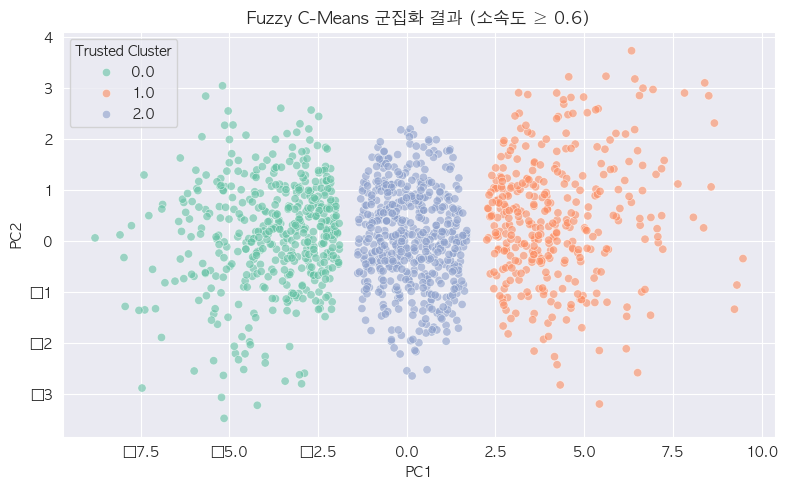

In [3]:
from fcmeans import FCM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# 한글 폰트 설정 (Mac 기준, 필요 시 Windows/Ubuntu에 맞게 수정)
plt.rcParams['font.family'] = 'AppleGothic'

# 1. 데이터 로드
df = pd.read_csv('dataset.csv')

# ✅ 분석 조건 설정
min_games_base = 6   # 1R 감독 최소 경기 수
min_games_mid = 20   # 중도 부임 감독 최소 경기 수
season_col = '년도'
round_col = '라운드'
manager_col = '감독'

# ✅ 시즌-팀 단위로 1라운드 당시 감독 추출
first_round_df = df[df[round_col] == 1][[season_col, '구단', manager_col]]
first_round_df = first_round_df.rename(columns={manager_col: '개막감독'})

# ✅ 감독별 시즌 내 지휘 경기 수 계산
manager_season_counts = (
    df.groupby([season_col, '구단', manager_col])
    .size()
    .reset_index(name='경기수')
)

# ✅ 개막감독 정보 merge
merged = pd.merge(manager_season_counts, first_round_df,
                  on=[season_col, '구단'], how='left')

# ✅ 포함 조건: (1R 지휘 + min_games_base) or (중도 부임 + min_games_mid)
condition_starting = (merged[manager_col] == merged['개막감독']) & (merged['경기수'] >= min_games_base)
condition_midseason = (merged[manager_col] != merged['개막감독']) & (merged['경기수'] >= min_games_mid)

valid_managers_df = merged[condition_starting | condition_midseason]

# ✅ 유효 감독만 필터링된 데이터프레임 생성
df = pd.merge(
    df,
    valid_managers_df[[season_col, '구단', manager_col]],
    on=[season_col, '구단', manager_col],
    how='inner'
)

print(f"✅ 필터링 후 경기 수: {len(df)}")
print(f"✅ 포함된 감독 수: {df['감독'].nunique()}")

# 2. 피처 선택 및 스케일링
X = df.drop(columns=['년도', '라운드', '구단', '감독', '상대', '득점', '실점'], errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 비지도 피처 선택 (VarianceThreshold)
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X_scaled)
selected_columns = X.columns[selector.get_support()]
print("✅ 선택된 피처:", selected_columns.tolist())

# 4. PCA (2차원 시각화용)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# 1. Fuzzy C-Means 적용
fcm = FCM(n_clusters=3, m=2.0, random_state=42)  # m은 퍼지 계수
fcm.fit(X_pca)

# 2. 소속도 행렬 (n_samples × n_clusters)
membership_matrix = fcm.u

# 3. 가장 높은 소속도와 해당 군집 라벨
df['fuzzy_cluster'] = membership_matrix.argmax(axis=1)
df['max_membership'] = membership_matrix.max(axis=1)

# 4. 신뢰할 수 있는 군집만 필터링 (threshold=0.6)
threshold = 0.6
df['trusted_cluster'] = df['fuzzy_cluster'].where(df['max_membership'] >= threshold, np.nan)

# 5. 필터링된 데이터만 추출
filtered_df = df[df['trusted_cluster'].notna()].copy()
filtered_df['trusted_cluster'] = filtered_df['trusted_cluster'].astype(int)

print(f"✅ 전체 샘플 수: {len(df)}")
print(f"✅ 소속도 ≥ {threshold} 기준 신뢰 샘플 수: {len(filtered_df)}")
print(f"✅ 클러스터별 샘플 수:\n{filtered_df['trusted_cluster'].value_counts()}")

# 6. 군집 품질 평가 (filtered data 기준)
sil_score = silhouette_score(X_pca[filtered_df.index], filtered_df['trusted_cluster'])
db_score = davies_bouldin_score(X_pca[filtered_df.index], filtered_df['trusted_cluster'])
ch_score = calinski_harabasz_score(X_pca[filtered_df.index], filtered_df['trusted_cluster'])

print(f"✅ Silhouette Score: {sil_score:.3f}")
print(f"✅ Davies-Bouldin Index: {db_score:.3f} (낮을수록 좋음)")
print(f"✅ Calinski-Harabasz Score: {ch_score:.3f} (클수록 좋음)")

# 7. 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df['trusted_cluster'],
    palette='Set2', alpha=0.6
)
plt.title(f'Fuzzy C-Means 군집화 결과 (소속도 ≥ {threshold})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Trusted Cluster')
plt.tight_layout()
plt.savefig('fuzzy_filtered_plot.png')
plt.show()



In [4]:
def calc_points(row):
    diff = row['득점'] - row['실점']
    if diff > 0:
        return 3
    elif diff == 0:
        return 1
    else:
        return 0

df['승점'] = df.apply(calc_points, axis=1)

# trusted_cluster 기준으로 성과 비교
result = (
    df[df['max_membership'] >= 0.6]
    .groupby('trusted_cluster')
    .agg(ppm=('승점', lambda x: x.sum()/len(x)),
         득점평균=('득점', 'mean'),
         실점평균=('실점', 'mean'),
         샘플수=('승점', 'count'))
    .reset_index()
)
print(result)


   trusted_cluster       ppm      득점평균      실점평균  샘플수
0              0.0  1.646552  1.364224  1.088362  464
1              1.0  1.187500  1.218750  1.355114  352
2              2.0  1.305182  1.213052  1.297505  521


In [5]:
crosstab_team = pd.crosstab(df['구단'], df[f'trusted_cluster'])

print(crosstab_team)

trusted_cluster  0.0  1.0  2.0
구단                            
강원                48   15   42
광주                33   25   41
김천                10   17   18
대구                88    4   33
대전                27   11   24
서울                14   49   39
성남                28    1   23
수원                32   10   33
수원FC              41   31   57
울산                 6   78   27
인천                50   15   49
전북                25   28   46
제주                38   25   47
포항                24   43   42


In [6]:
from scipy.stats import chi2_contingency
algorithm = 'trusted_cluster'
# 카이제곱 검정
chi2_team, p_team, dof_team, expected_team = chi2_contingency(crosstab_team)

print(f" [구단 vs {algorithm} 군집] 카이제곱 통계량:", chi2_team)
print("p-value:", p_team)
print("자유도:", dof_team)

# 카이제곱 검정
crosstab_manager = pd.crosstab(filtered_df['감독'], filtered_df[f'{algorithm}'])
chi2_mgr, p_mgr, dof_mgr, expected_mgr = chi2_contingency(crosstab_manager)

print(f" [감독 vs {algorithm} 군집] 카이제곱 통계량:", chi2_mgr)
print("p-value:", p_mgr)
print("자유도:", dof_mgr)
print(crosstab_manager)

 [구단 vs trusted_cluster 군집] 카이제곱 통계량: 293.4333613332795
p-value: 4.3246176294160266e-47
자유도: 26
 [감독 vs trusted_cluster 군집] 카이제곱 통계량: 401.0535755087754
p-value: 1.67159253288017e-54
자유도: 54
trusted_cluster   0   1   2
감독                         
가마               16   1   7
김기동              25  42  46
김남일              28   1  23
김도균              30  19  50
김두현               5   7   7
김병수              12  11  20
김상식              14  20  33
김은중              11  12   7
김태완               3  12   6
김학범               9   4  14
김호영              26   3   6
남기일              29  21  33
박건하              17   5  18
박진섭               7   5  10
박창현              13   2  11
박태하               4  15  11
안익수               2  30  14
윤정환               8   5  16
이민성              19   8  17
이병근              37   4  16
이정효               7  22  35
정정용               7   5  12
조성환              50  15  49
최용수              32   1  13
최원권              33   0   7
페트레스쿠             6   1   6
홍명보               6  78  2

In [7]:
def cramers_v(chi2, n, k_row, k_col):
    denom = n * (min(k_row - 1, k_col - 1))
    if denom == 0:
        return None
    return np.sqrt(chi2 / denom)

def compare_cramers_v(v1, v2, n):
    se = np.sqrt((1 - v1**2)/n + (1 - v2**2)/n)
    z = (v2 - v1) / se
    from scipy.stats import norm
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

# 샘플 수 (경기 수)
n = len(filtered_df)

# 팀 vs 군집
v_team = cramers_v(chi2_team, n, crosstab_team.shape[0], crosstab_team.shape[1])

# 감독 vs 군집
v_mgr = cramers_v(chi2_mgr, n, crosstab_manager.shape[0], crosstab_manager.shape[1])

print(f" Cramér's V (팀 vs 군집): {v_team:.4f}")
print(f" Cramér's V (감독 vs 군집): {v_mgr:.4f}")

z_value, p_value = compare_cramers_v(v_team, v_mgr, n=len(df))

print(f" Z = {z_value:.3f}")
print(f" p-value = {p_value:.5f}")

 Cramér's V (팀 vs 군집): 0.3313
 Cramér's V (감독 vs 군집): 0.3873
 Z = 1.735
 p-value = 0.08281


In [8]:
from scipy.stats import f_oneway
import pandas as pd

# 1. 신뢰 샘플만 필터링
filtered_df = df[df['max_membership'] >= 0.6].copy()
filtered_df['trusted_cluster'] = filtered_df['trusted_cluster'].astype(int)

# 2. 사용된 피처 리스트
features = selected_columns.tolist()

# 3. 클러스터별 피처 평균값 출력
feature_means = filtered_df.groupby('trusted_cluster')[features].mean().round(3)
print("✅ 클러스터별 피처 평균값:\n")
print(feature_means)

# 4. 각 피처에 대해 ANOVA 진행
anova_results = []

for feature in features:
    groups = [group[feature].dropna().values for _, group in filtered_df.groupby('trusted_cluster')]
    stat, pval = f_oneway(*groups)
    anova_results.append({'피처': feature, 'F값': stat, 'p값': pval})

anova_df = pd.DataFrame(anova_results).sort_values('p값')
anova_df['유의'] = anova_df['p값'] < 0.05
print("\n✅ ANOVA 결과 (클러스터 간 피처 차이):\n")
print(anova_df)


✅ 클러스터별 피처 평균값:

                    점유율  패스성공률(%)    패스 성공    키패스  공격진영 패스  중앙지역 패스  수비진영 패스  \
trusted_cluster                                                                
0                38.844     0.752  260.110  5.651   45.901  136.489   77.720   
1                61.840     0.879  562.832  7.989  108.710  339.057  115.065   
2                50.788     0.831  403.192  6.555   66.825  228.979  107.388   

                    롱패스    중거리패스    단거리패스     전방패스      횡패스     후방패스    크로스  \
trusted_cluster                                                               
0                28.741   92.610  138.759   98.319   98.196   63.595  3.315   
1                40.142  213.787  308.898  184.761  238.514  139.551  5.602   
2                34.664  151.081  217.447  139.309  163.361  100.522  4.399   

                      패스  공격진영 패스 비율  단거리패스 비율  전방패스 비율  
trusted_cluster                                          
0                343.996       0.134     0.401    0.286  
1           

In [9]:
def permutation_test(df, group_col='감독', cluster_col='trusted_cluster',
                     n_permutations=1000, seed=42, verbose=False):
    np.random.seed(seed)

    # 1. 실제 chi² 통계량 계산
    observed_ct = pd.crosstab(df[group_col], df[cluster_col])

    if observed_ct.shape[0] <= 1 or observed_ct.shape[1] <= 1:
        if verbose:
            print("❗ 관측 교차표 차원이 너무 작아 chi² 계산 불가")
        return np.nan, np.nan, []

    try:
        observed_chi2, _, _, _ = chi2_contingency(observed_ct)
    except Exception as e:
        if verbose:
            print(f"❗ chi² 계산 오류: {e}")
        return np.nan, np.nan, []

    # 2. 순열 통계량 생성
    chi2_distribution = []
    successful = 0

    for _ in range(n_permutations):
        shuffled = filtered_df[group_col].sample(frac=1, replace=False).reset_index(drop=True)
        shuffled_df = filtered_df.copy()
        shuffled_df[group_col] = shuffled

        ct = pd.crosstab(shuffled_df[group_col], shuffled_df[cluster_col])

        if ct.shape[0] > 1 and ct.shape[1] > 1:
            try:
                chi2, _, _, _ = chi2_contingency(ct)
                chi2_distribution.append(chi2)
                successful += 1
            except:
                continue

    if verbose:
        print(f"✅ 성공적으로 수행된 permutation 수: {successful}/{n_permutations}")

    # 3. 순열 결과 없음 방지
    if len(chi2_distribution) == 0:
        if verbose:
            print("❗ 유효한 permutation 결과가 없습니다.")
        return observed_chi2, np.nan, []

    # 4. p-value 계산
    p_perm = np.mean(np.array(chi2_distribution) >= observed_chi2)
    return observed_chi2, p_perm, chi2_distribution

team_manager_list = [
    {'강원': ['김병수', '최용수', '윤정환']},
    {'광주': ['김호영', '이정효']},
    {'김천': ['김태완', '정정용']},
    {'대구': ['이병근', '가마', '최원권', '박창현']},
    {'대전': ['이민성', '황선홍']},
    {'서울': ['박진섭', '안익수', '김기동']},
    {'수원': ['박건하', '이병근', '김병수']},
    {'수원FC': ['김도균', '김은중']},
    {'전북': ['김상식', '김두현', '페트레스쿠', '조성환']},
    {'제주': ['남기일', '김학범']},
    {'포항': ['김기동', '박태하']}
]

results = []

# 분석 반복
for item in team_manager_list:
    for team, managers in item.items():
        # 데이터 필터링: 해당 팀 + 해당 감독들만
        df_sub = filtered_df[(filtered_df['구단'] == team) & (filtered_df['감독'].isin(managers))]

        ct = pd.crosstab(df_sub['감독'], df_sub['trusted_cluster'])

        print(f"\n📋 {team} 교차표")
        print(ct)

        if df_sub['감독'].nunique() >= 2 and df_sub['trusted_cluster'].nunique() > 1 and ct.shape[0] > 1 and ct.shape[1] > 1:
            try:
                chi2, p, dof, expected = chi2_contingency(ct)
                n = df_sub.shape[0]
                v = cramers_v(chi2, n, ct.shape[0], ct.shape[1])
                
                # permutation test
                chi2_val, p_perm, chi2_dist = permutation_test(df_sub)

                print(f"📊 {team} Observed chi²: {chi2_val:.3f}")

                results.append({
                    '팀': team,
                    '감독 수': ct.shape[0],
                    '경기 수': n,
                    'chi2': round(chi2, 3),
                    'p-value': round(p, 5),
                    "Cramér's V": round(v, 4) if v is not None else None,
                })

            except Exception as e:
                print(f"❗ {team} 계산 오류:", e)
                results.append({
                    '팀': team,
                    '감독 수': ct.shape[0],
                    '경기 수': df_sub.shape[0],
                    'chi2': None,
                    'p-value': None,
                    "Cramér's V": None,
                })
        else:
            results.append({
                '팀': team,
                '감독 수': ct.shape[0],
                '경기 수': df_sub.shape[0],
                'chi2': None,
                'p-value': None,
                "Cramér's V": None,
            })

# 결과 DataFrame 생성 및 정렬
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("Cramér's V", ascending=False, na_position='last')
print(df_results)


📋 강원 교차표
trusted_cluster   0  1   2
감독                        
김병수               8  9  13
윤정환               8  5  16
최용수              32  1  13
📊 강원 Observed chi²: 23.614

📋 광주 교차표
trusted_cluster   0   1   2
감독                         
김호영              26   3   6
이정효               7  22  35
📊 광주 Observed chi²: 40.907

📋 김천 교차표
trusted_cluster  0   1   2
감독                        
김태완              3  12   6
정정용              7   5  12
📊 김천 Observed chi²: 6.310

📋 대구 교차표
trusted_cluster   0  1   2
감독                        
가마               16  1   7
박창현              13  2  11
이병근              26  1   8
최원권              33  0   7
📊 대구 Observed chi²: 9.422

📋 대전 교차표
trusted_cluster   0  1   2
감독                        
이민성              19  8  17
황선홍               8  3   7
📊 대전 Observed chi²: 0.021

📋 서울 교차표
trusted_cluster  0   1   2
감독                        
김기동              5  14  15
박진섭              7   5  10
안익수              2  30  14
📊 서울 Observed chi²: 15.651

📋 수원 교차표
trusted_clu

In [10]:
filtered_df

,년도,라운드,구단,감독,상대,득점,실점,점유율,패스성공률(%),패스 성공,...,후방패스,크로스,패스,공격진영 패스 비율,단거리패스 비율,전방패스 비율,fuzzy_cluster,max_membership,trusted_cluster,승점
1,2021,1,서울,박진섭,전북,0,2,48.2,0.76,371,...,90,3,488.0,0.141393,0.397541,0.272541,2,0.789461,2,0
2,2021,1,대구,이병근,수원FC,1,1,54.1,0.79,428,...,104,3,541.0,0.133087,0.421442,0.301294,2,0.973319,2,1
3,2021,1,수원FC,김도균,대구,1,1,45.9,0.78,358,...,94,2,458.0,0.111354,0.517467,0.281659,2,0.655802,2,1
5,2021,1,인천,조성환,포항,1,2,41.3,0.77,315,...,92,0,409.0,0.097800,0.444988,0.273839,0,0.860284,0,0
6,2021,1,수원,박건하,광주,1,0,62.6,0.82,515,...,140,7,628.0,0.216561,0.455414,0.286624,1,0.855830,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,2024,38,광주,이정효,전북,1,1,58.6,0.86,450,...,111,6,523.0,0.103250,0.437859,0.304015,2,0.770877,2,1
1665,2024,38,전북,김두현,광주,1,1,41.4,0.79,315,...,85,5,398.0,0.045226,0.414573,0.248744,0,0.706146,0,1
1666,2024,38,대구,박창현,인천,1,3,47.5,0.80,360,...,91,5,450.0,0.100000,0.455556,0.286667,2,0.697397,2,0
1667,2024,38,대전,황선홍,제주,2,1,46.2,0.82,298,...,75,3,363.0,0.184573,0.426997,0.319559,0,0.731118,0,3


In [11]:
# 군집별 PPM 리스트
groups = [filtered_df[filtered_df['trusted_cluster'] == k]['승점'] for k in sorted(filtered_df['trusted_cluster'].unique())]

for group in groups:
    print(group)
    print(group.mean())
    
# 일원분산분석
f_stat, p_value = f_oneway(*groups)
print(f"📊 ANOVA F = {f_stat:.3f}, p = {p_value:.5f}")


5       0
7       0
12      1
14      0
17      0
       ..
1658    0
1661    3
1662    3
1665    1
1667    3
Name: 승점, Length: 464, dtype: int64
1.646551724137931
6       3
8       3
15      3
20      3
23      0
       ..
1639    0
1645    0
1652    0
1657    3
1663    0
Name: 승점, Length: 352, dtype: int64
1.1875
1       0
2       1
3       1
9       0
10      1
       ..
1655    1
1656    1
1664    1
1666    0
1668    0
Name: 승점, Length: 521, dtype: int64
1.3051823416506718
📊 ANOVA F = 14.795, p = 0.00000


In [12]:
# PPM 계산: cluster_kmeans × 감독 × 구단 단위
ppm_df = (
    filtered_df.groupby(['trusted_cluster', '감독', '구단'])
    .agg(경기수=('승점', 'count'), 총승점=('승점', 'sum'))
    .reset_index()
)
ppm_df['ppm'] = ppm_df['총승점'] / ppm_df['경기수']

# 결과 확인
print(ppm_df.head())


import statsmodels.formula.api as smf

model_ppm = smf.ols('ppm ~ C(trusted_cluster)', data=ppm_df).fit()
print(model_ppm.summary())

model_ppm_with_club = smf.ols('ppm ~ C(trusted_cluster) + C(구단)', data=ppm_df).fit()
print(model_ppm_with_club.summary())


   trusted_cluster   감독    구단  경기수  총승점       ppm
0                0   가마    대구   16   15  0.937500
1                0  김기동    서울    5    9  1.800000
2                0  김기동    포항   20   38  1.900000
3                0  김남일    성남   28   34  1.214286
4                0  김도균  수원FC   30   45  1.500000
                            OLS Regression Results                            
Dep. Variable:                    ppm   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     20.06
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           6.44e-08
Time:                        19:57:51   Log-Likelihood:                -78.074
No. Observations:                  92   AIC:                             162.1
Df Residuals:                      89   BIC:                             169.7
Df Model:                           2                               

In [13]:
filtered_df[filtered_df['trusted_cluster'] == 0].groupby('감독')['승점'].mean().sort_values(ascending=False)


감독
안익수      3.000000
황선홍      2.750000
페트레스쿠    2.666667
윤정환      2.625000
박태하      2.500000
이정효      2.285714
김상식      2.285714
정정용      2.142857
김은중      2.090909
홍명보      2.000000
이병근      1.972973
남기일      1.931034
김기동      1.880000
이민성      1.842105
박창현      1.692308
김학범      1.666667
조성환      1.620000
박건하      1.588235
김도균      1.500000
최원권      1.454545
최용수      1.437500
김남일      1.214286
김두현      1.200000
김태완      1.000000
가마       0.937500
김병수      0.916667
김호영      0.846154
박진섭      0.714286
Name: 승점, dtype: float64

In [14]:
# 신뢰 클러스터 샘플만
trusted_df = df[df['max_membership'] >= 0.6].copy()

# 클러스터별 총승점 / 총경기수 계산
cluster_perf = (
    trusted_df
    .groupby('trusted_cluster')
    .agg(총승점=('승점', 'sum'), 총경기수=('승점', 'count'))
    .assign(ppm=lambda x: x['총승점'] / x['총경기수'])
)
print(cluster_perf)


                 총승점  총경기수       ppm
trusted_cluster                     
0.0              764   464  1.646552
1.0              418   352  1.187500
2.0              680   521  1.305182


In [15]:
import statsmodels.api as sm

# 가중치 = 경기 수
weights = ppm_df['경기수']

# 회귀 모델 (클러스터만)
model_wls = sm.WLS.from_formula('ppm ~ C(trusted_cluster)', data=ppm_df, weights=weights).fit()
print(model_wls.summary())

# 회귀 모델 (클러스터 + 구단)
model_wls_with_club = sm.WLS.from_formula('ppm ~ C(trusted_cluster) + C(구단)', data=ppm_df, weights=weights).fit()
print(model_wls_with_club.summary())


                            WLS Regression Results                            
Dep. Variable:                    ppm   R-squared:                       0.131
Model:                            WLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     6.701
Date:                Tue, 08 Jul 2025   Prob (F-statistic):            0.00195
Time:                        19:57:51   Log-Likelihood:                -83.274
No. Observations:                  92   AIC:                             172.5
Df Residuals:                      89   BIC:                             180.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [16]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# 예시용 데이터프레임 불러오기
# df = pd.read_csv('your_data.csv')  # 혹은 이미 로드된 df 사용

# 범주형 변수 처리
ppm_df['trusted_cluster'] = ppm_df['trusted_cluster'].astype('category')
ppm_df['구단'] = ppm_df['구단'].astype('category')

# 회귀식 정의
formula = 'ppm ~ C(trusted_cluster) + C(구단)'

# OLS 모델 적합
ols_model = smf.ols(formula=formula, data=ppm_df).fit()

# 잔차 및 예측값 추출
resid = ols_model.resid
fitted = ols_model.fittedvalues

# Breusch-Pagan test
bp_test = het_breuschpagan(resid, ols_model.model.exog)

# 결과 출력
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(bp_labels, bp_test)))

# White's test
white_test = het_white(resid, ols_model.model.exog)

# 결과 출력
white_labels = ['Test Statistic', 'Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(white_labels, white_test)))


{'Lagrange multiplier statistic': 21.90968912124806, 'p-value': 0.11019391939318686, 'f-value': 1.583800815774517, 'f p-value': 0.09846591948895049}
{'Test Statistic': 40.420366882696754, 'Test p-value': 0.49621881367689447, 'F-Statistic': 0.9556704335730517, 'F-Test p-value': 0.5562087990044328}


In [17]:
from tabulate import tabulate

# Breusch-Pagan Test 결과
bp_result = {
    "Test": "Breusch-Pagan",
    "LM Statistic": round(bp_test[0], 3),
    "LM p-value": round(bp_test[1], 4),
    "F Statistic": round(bp_test[2], 3),
    "F p-value": round(bp_test[3], 4),
}

# White's Test 결과
white_result = {
    "Test": "White",
    "LM Statistic": round(white_test[0], 3),
    "LM p-value": round(white_test[1], 4),
    "F Statistic": round(white_test[2], 3),
    "F p-value": round(white_test[3], 4),
}

# 두 결과를 표로 출력
print(tabulate([bp_result, white_result], headers="keys", tablefmt="pretty"))


+---------------+--------------+------------+-------------+-----------+
|     Test      | LM Statistic | LM p-value | F Statistic | F p-value |
+---------------+--------------+------------+-------------+-----------+
| Breusch-Pagan |    21.91     |   0.1102   |    1.584    |  0.0985   |
|     White     |    40.42     |   0.4962   |    0.956    |  0.5562   |
+---------------+--------------+------------+-------------+-----------+


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def ratio_viz(team_name):
    team_df = filtered_df[filtered_df['구단'] == team_name].copy()

    # 전술 군집 비율 계산
    tactical_ratio = (
        team_df.groupby(['년도', 'trusted_cluster'])
        .size()
        .reset_index(name='경기수')
    )
    tactical_ratio['전술군집비율'] = tactical_ratio.groupby('년도')['경기수'].transform(lambda x: x / x.sum())

    # 승점 비율 계산
    tactical_ppm = (
        team_df.groupby(['년도', 'trusted_cluster'])['승점']
        .sum()
        .reset_index()
    )
    tactical_ppm['승점비율'] = tactical_ppm.groupby('년도')['승점'].transform(lambda x: x / x.sum())

    # 시각화
    unique_years = sorted(team_df['년도'].unique())
    num_years = len(unique_years)
    fig, axes = plt.subplots(num_years, 2, figsize=(12, 4 * num_years))

    if num_years == 1:
        axes = [axes]  # 한 해만 있을 때 2D 배열로

    for idx, year in enumerate(unique_years):
        ax1 = axes[idx][0]
        sns.barplot(
            data=tactical_ratio[tactical_ratio['년도'] == year],
            x='trusted_cluster', y='전술군집비율', ax=ax1, palette='Set2'
        )
        ax1.set_title(f'{team_name} - {year}년 전술 군집 비율')
        ax1.set_ylim(0, 1)

        ax2 = axes[idx][1]
        sns.barplot(
            data=tactical_ppm[tactical_ppm['년도'] == year],
            x='trusted_cluster', y='승점비율', ax=ax2, palette='Set3'
        )
        ax2.set_title(f'{team_name} - {year}년 군집별 승점 비율')
        ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

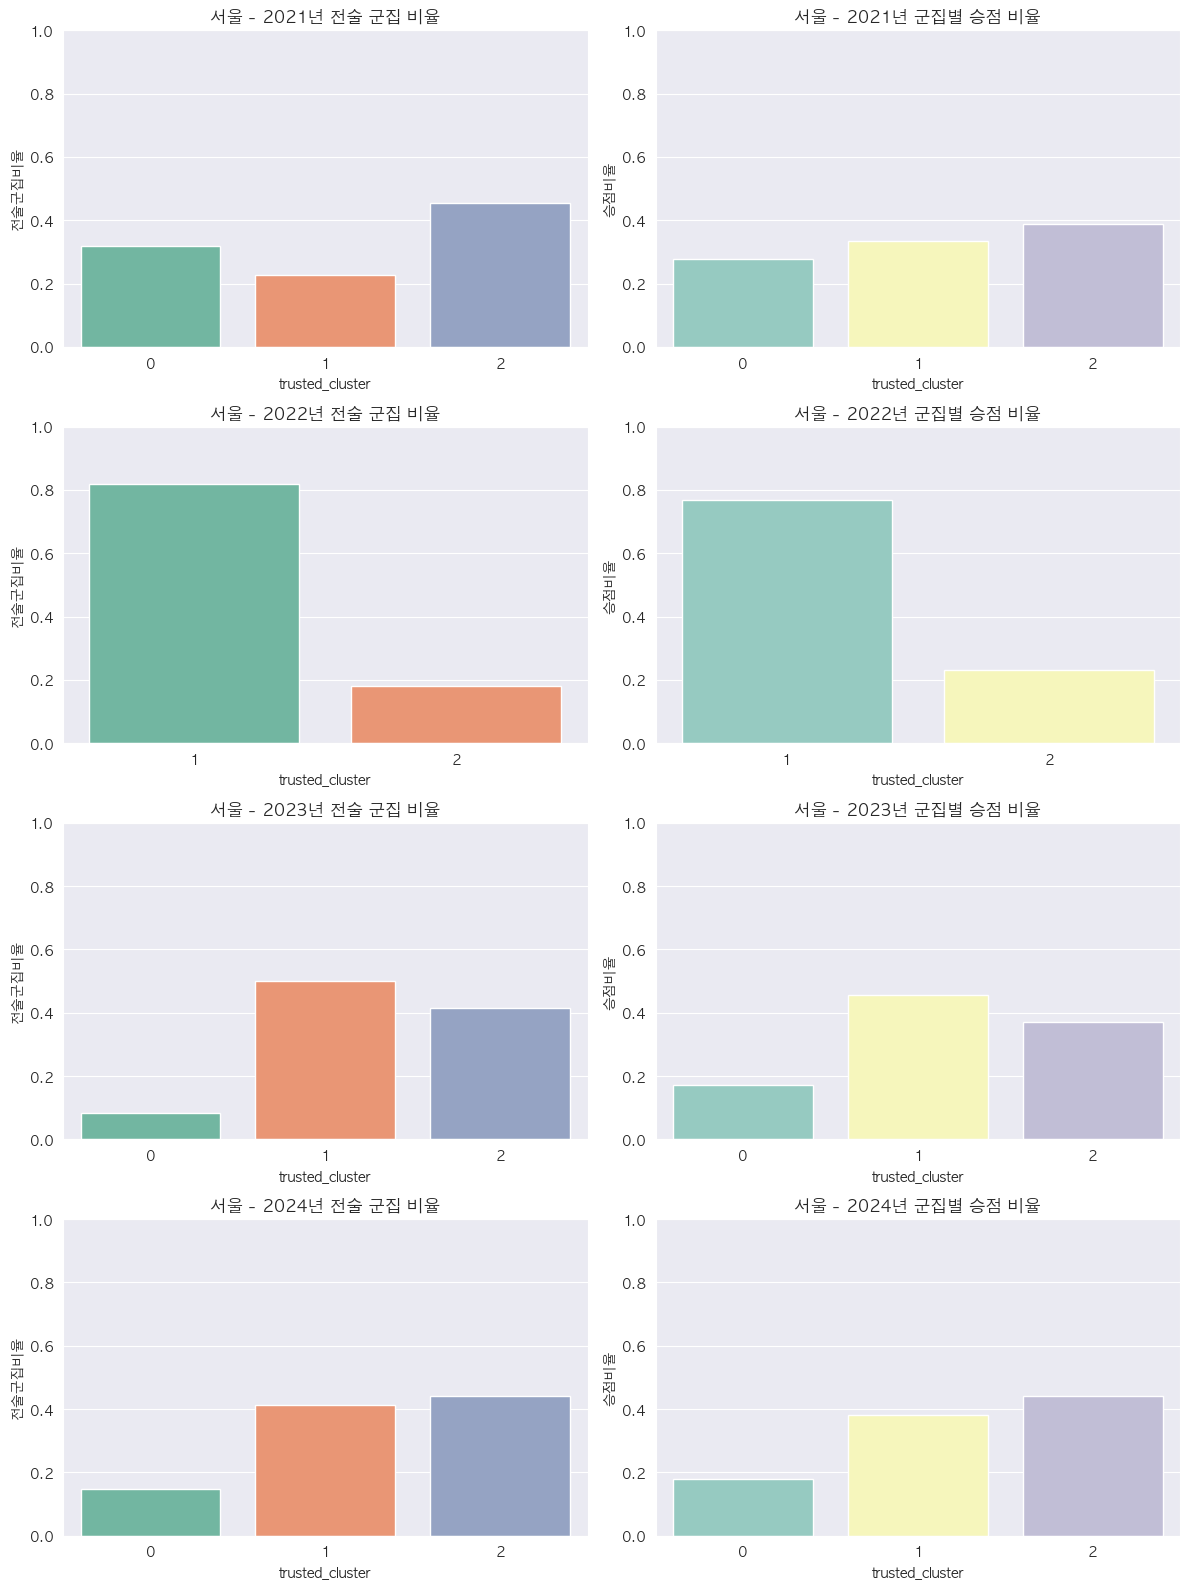

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

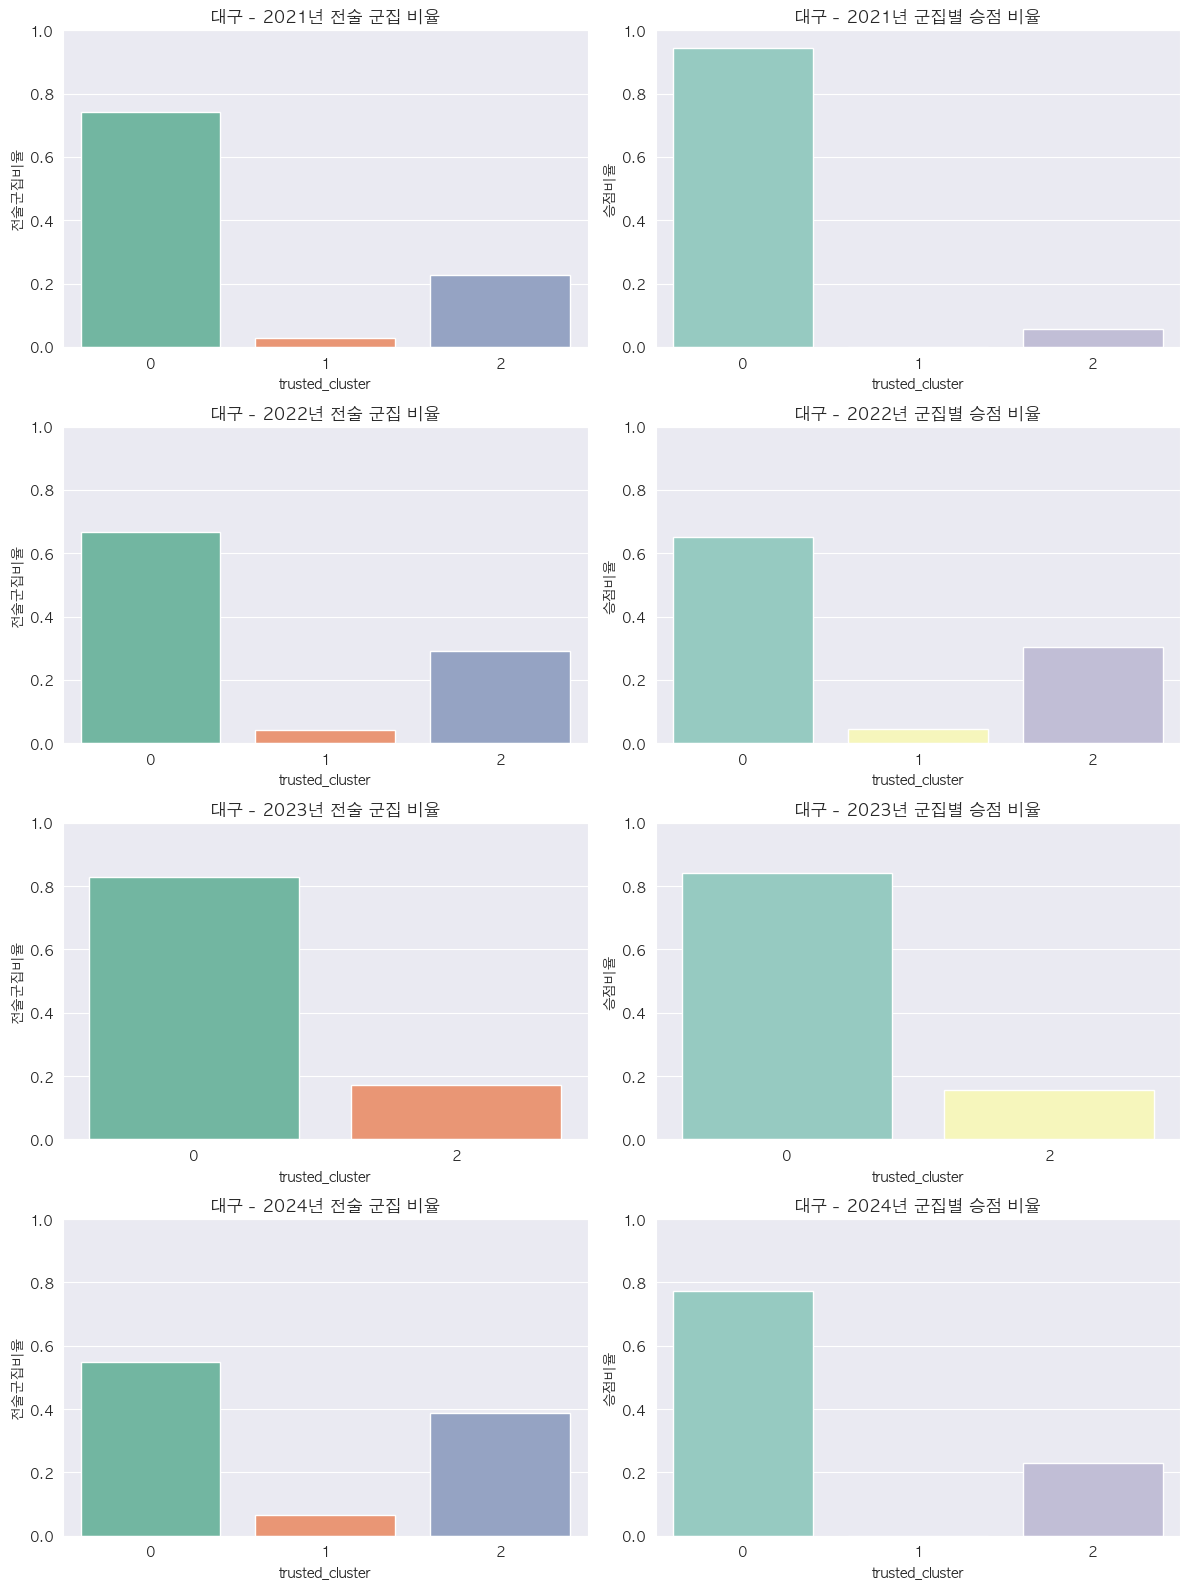

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

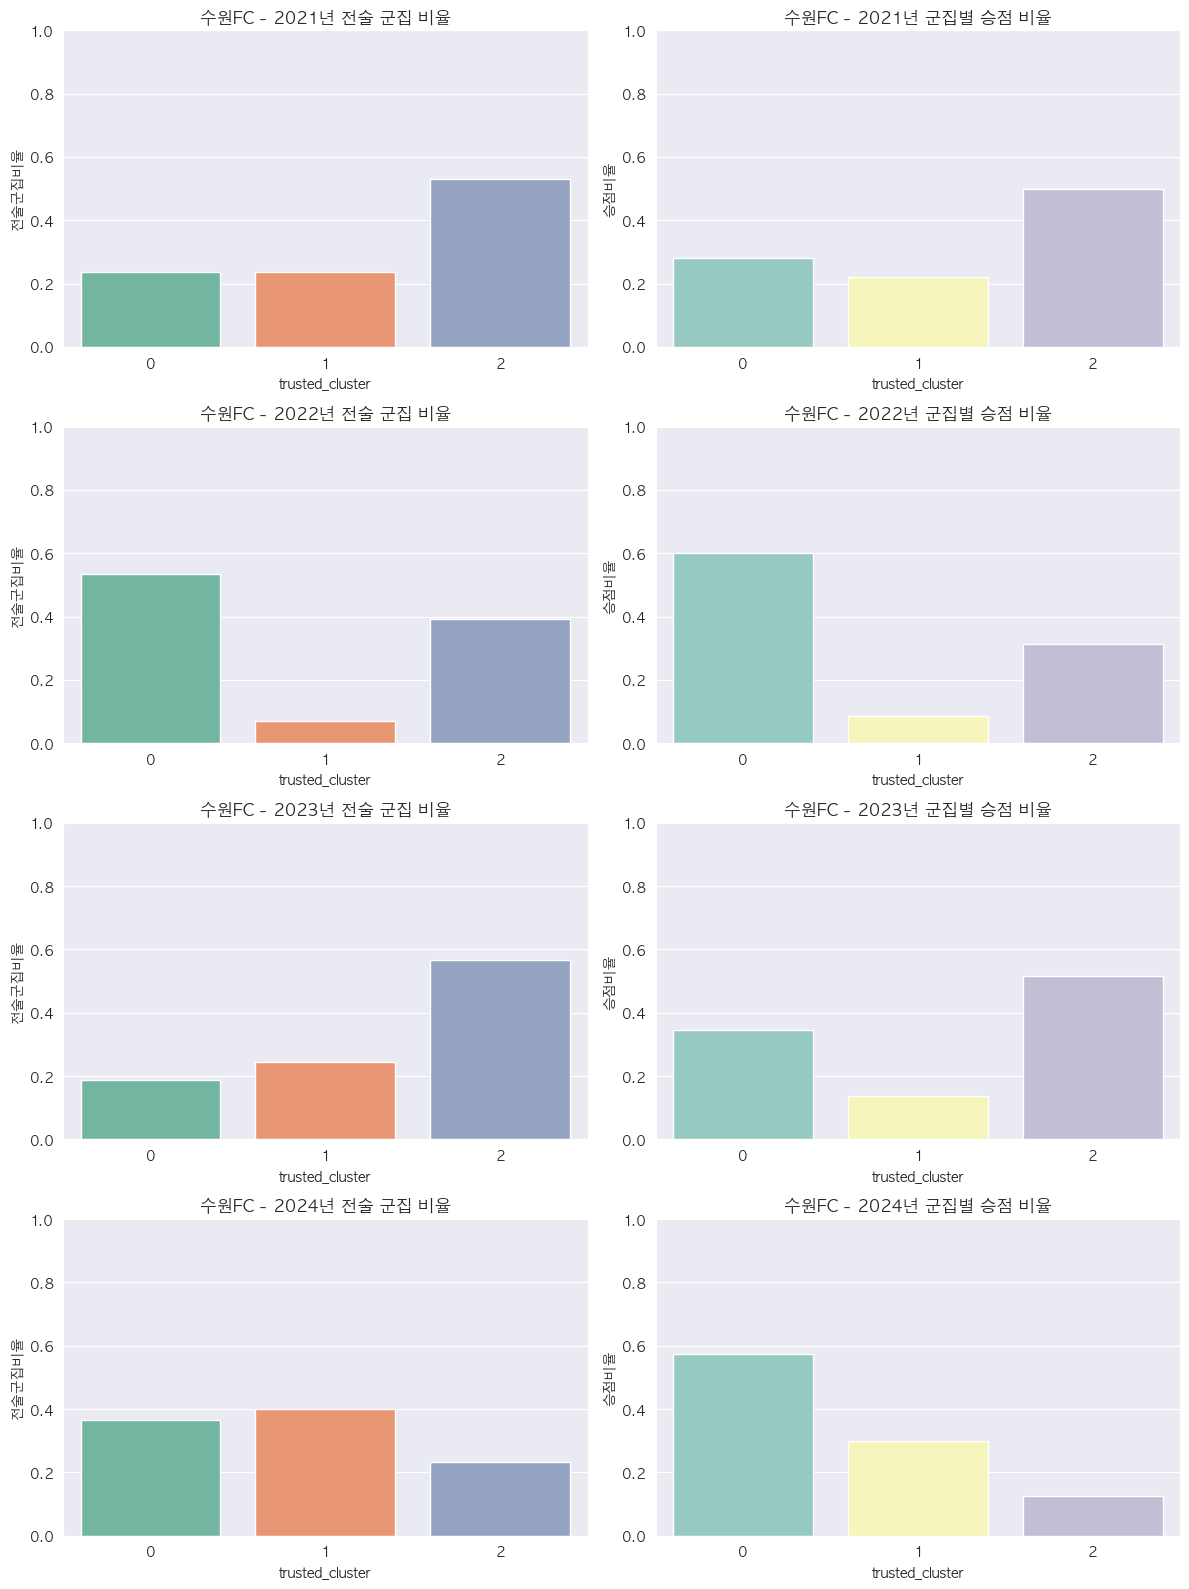

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

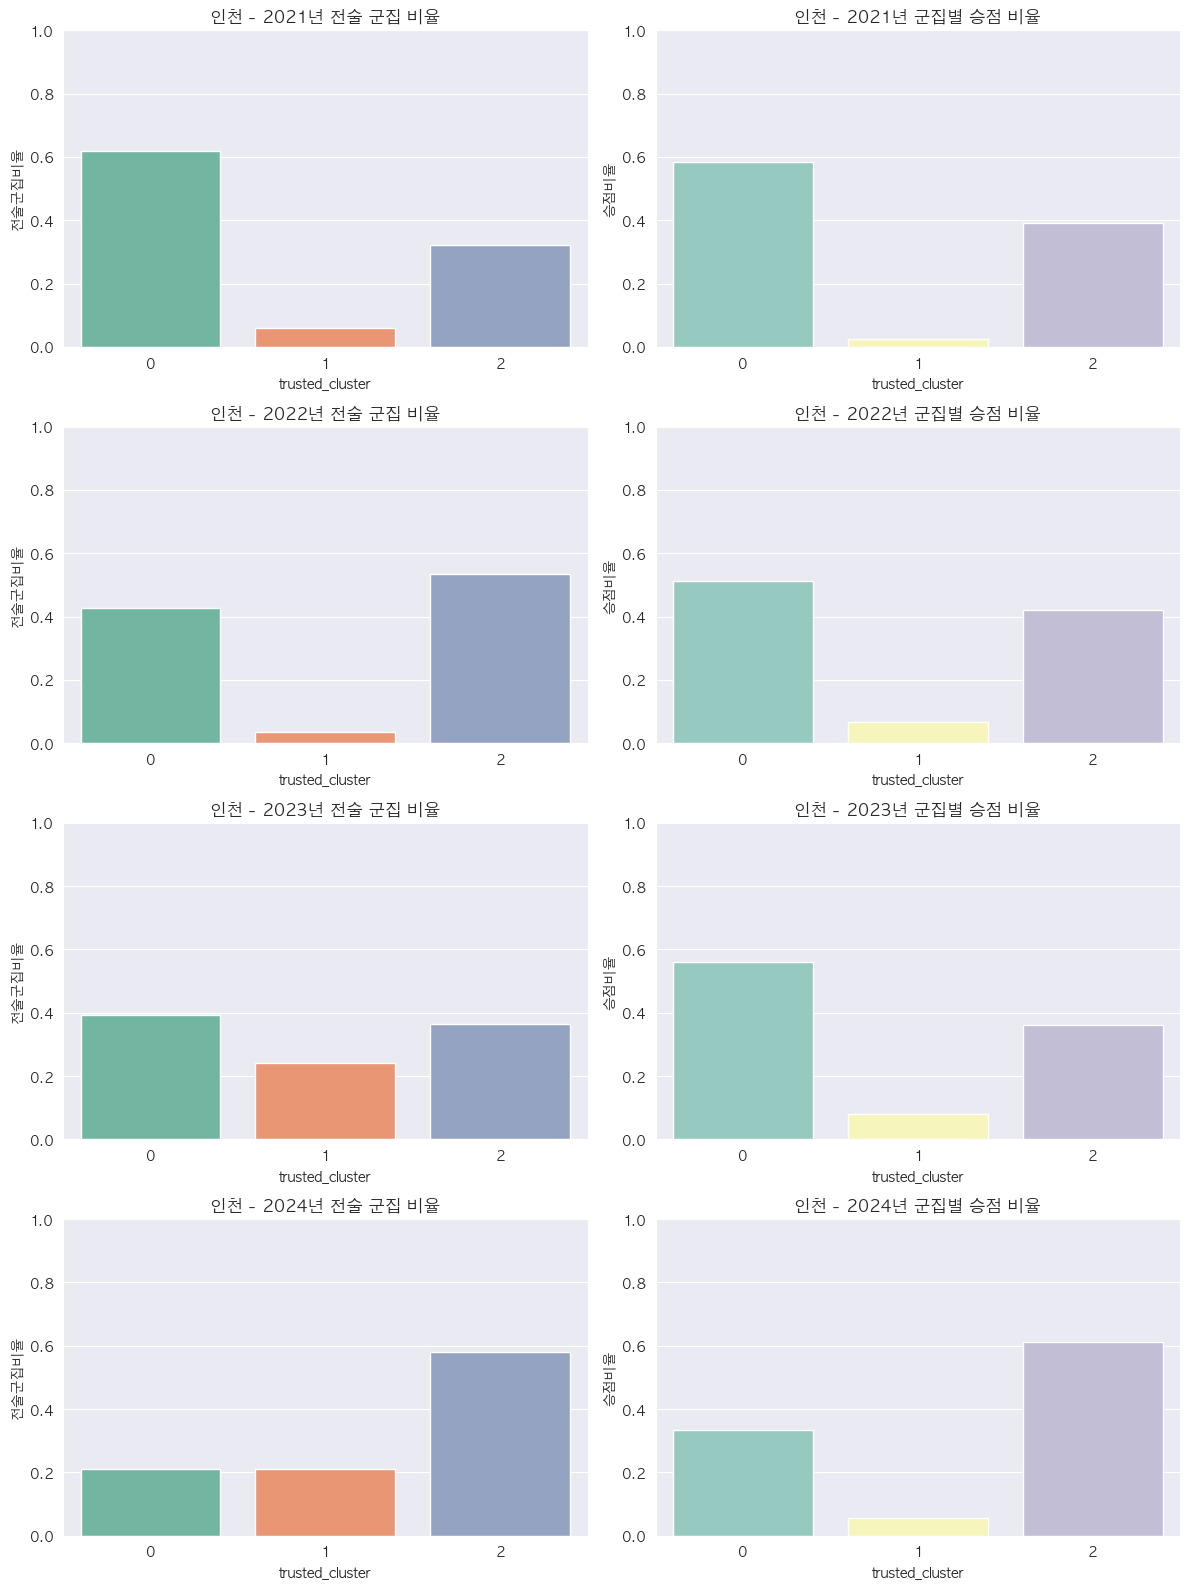

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

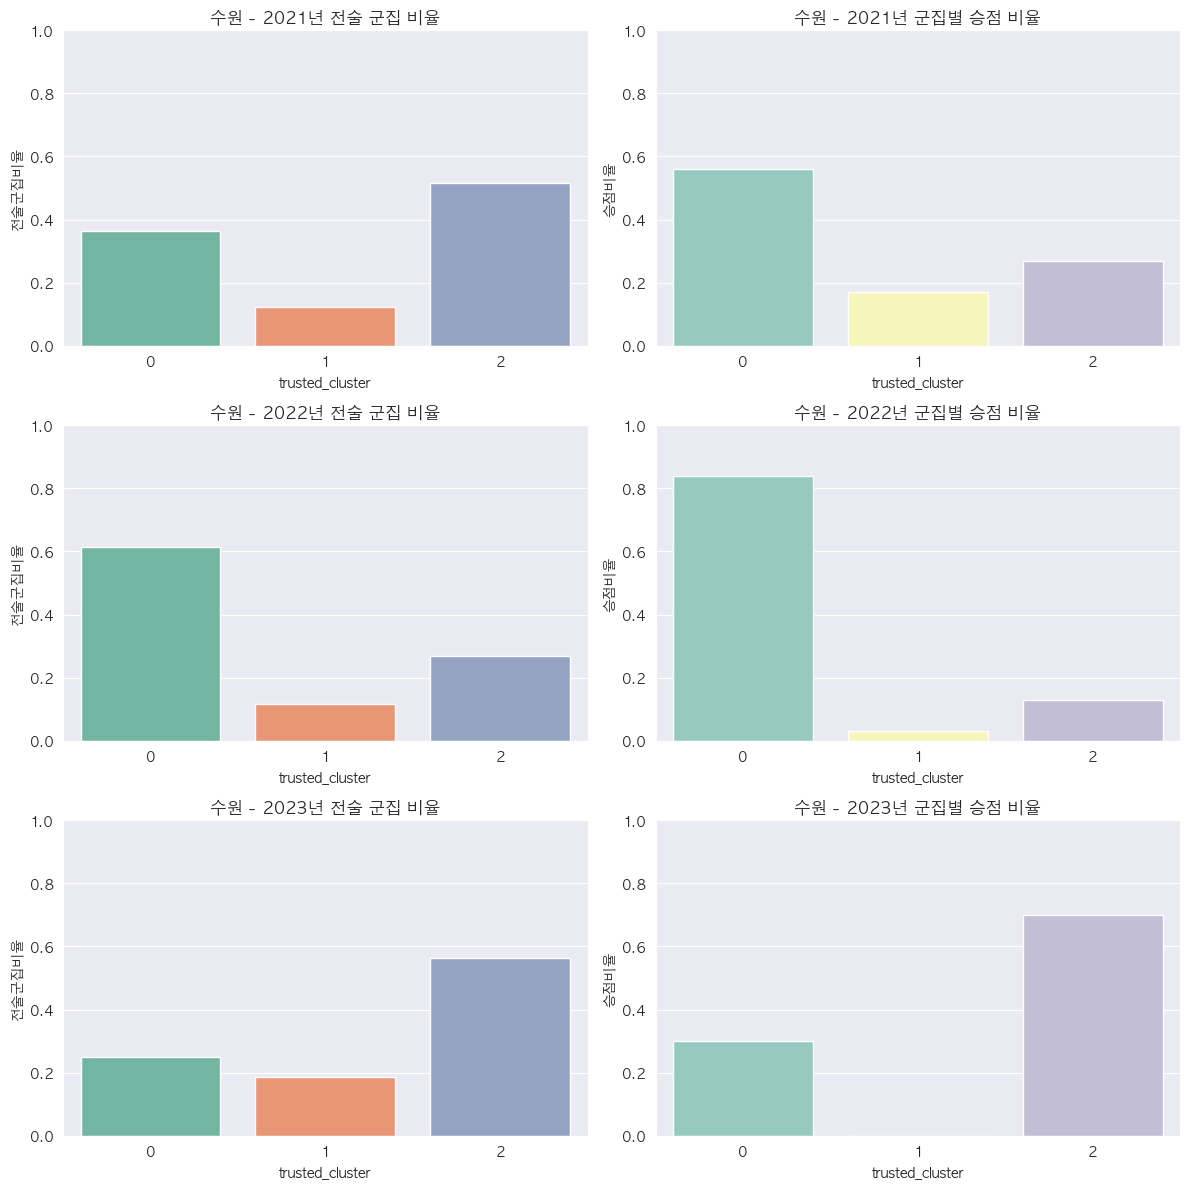

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

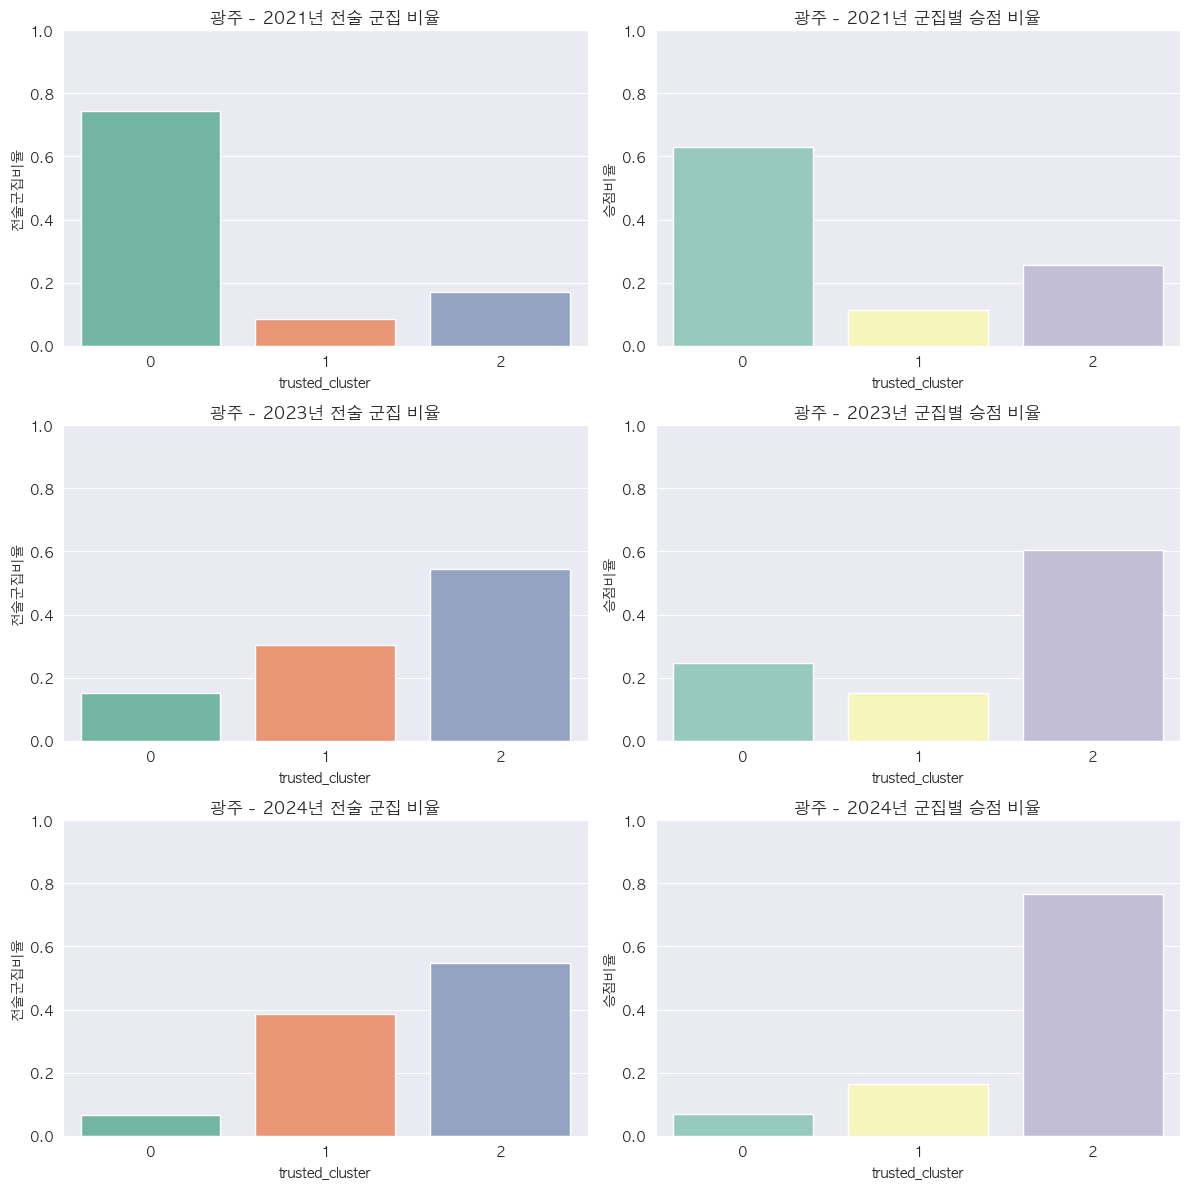

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

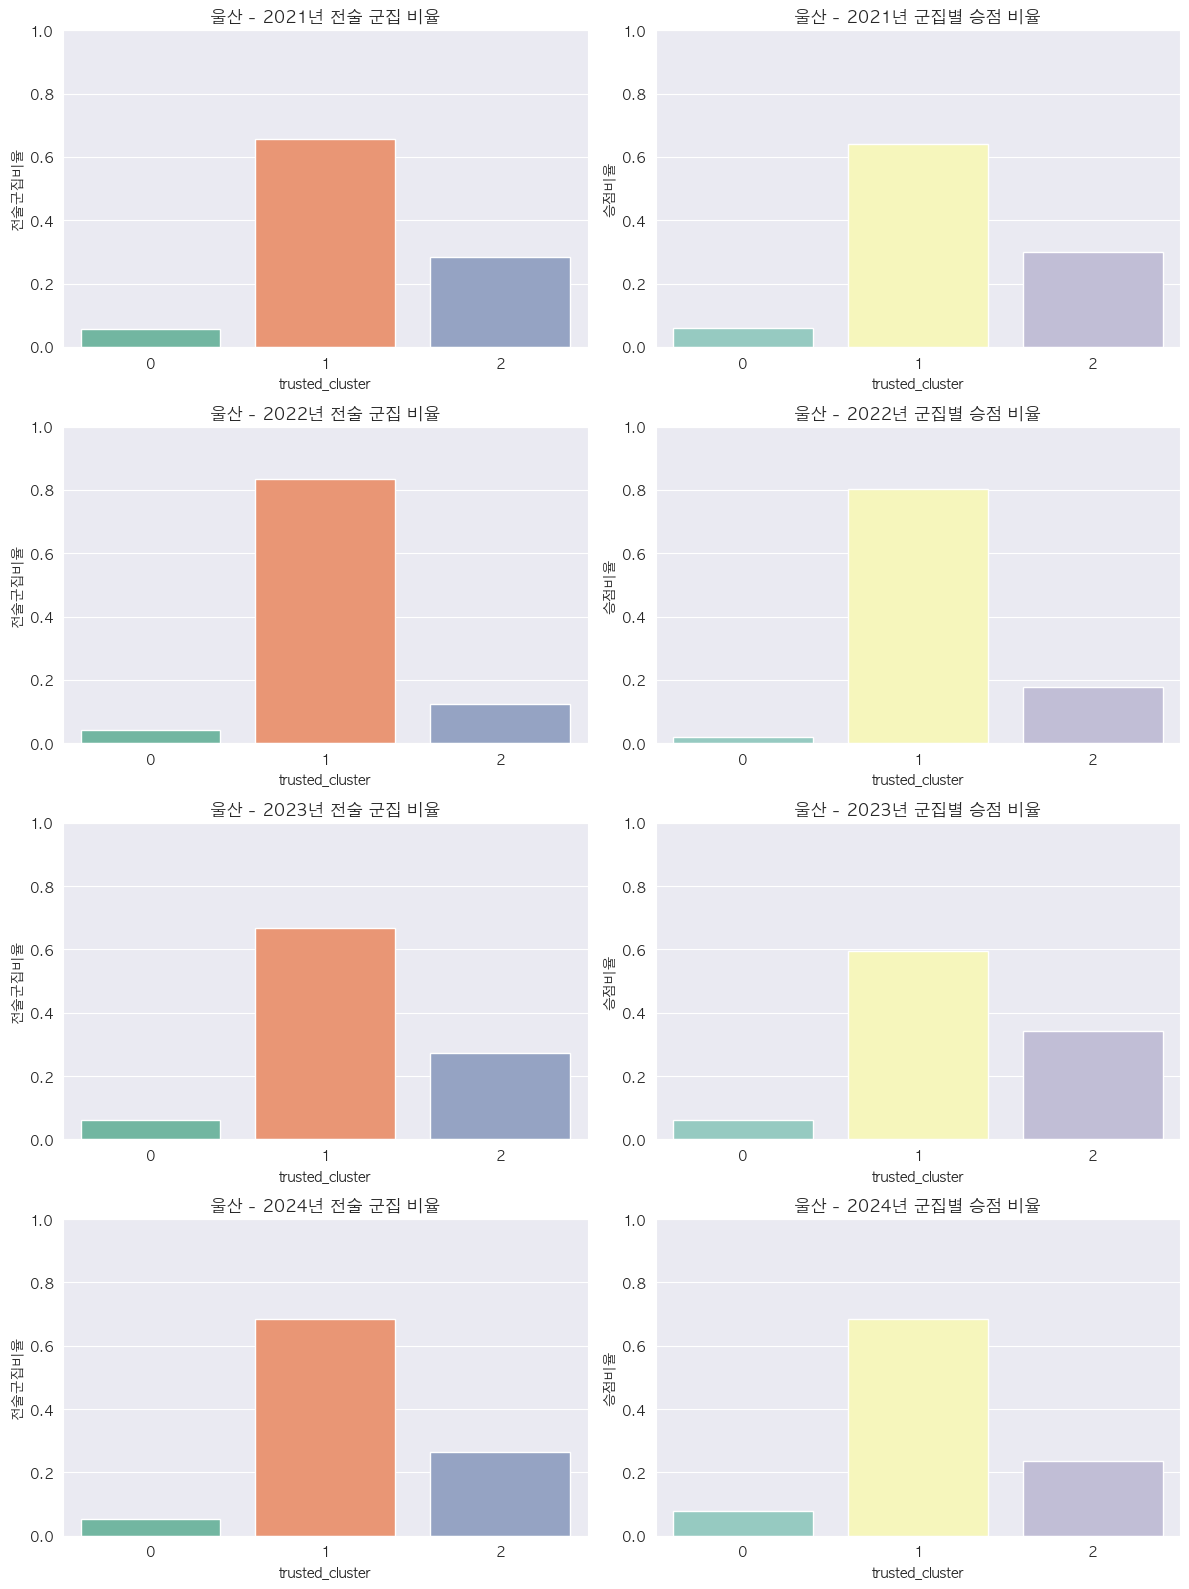

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

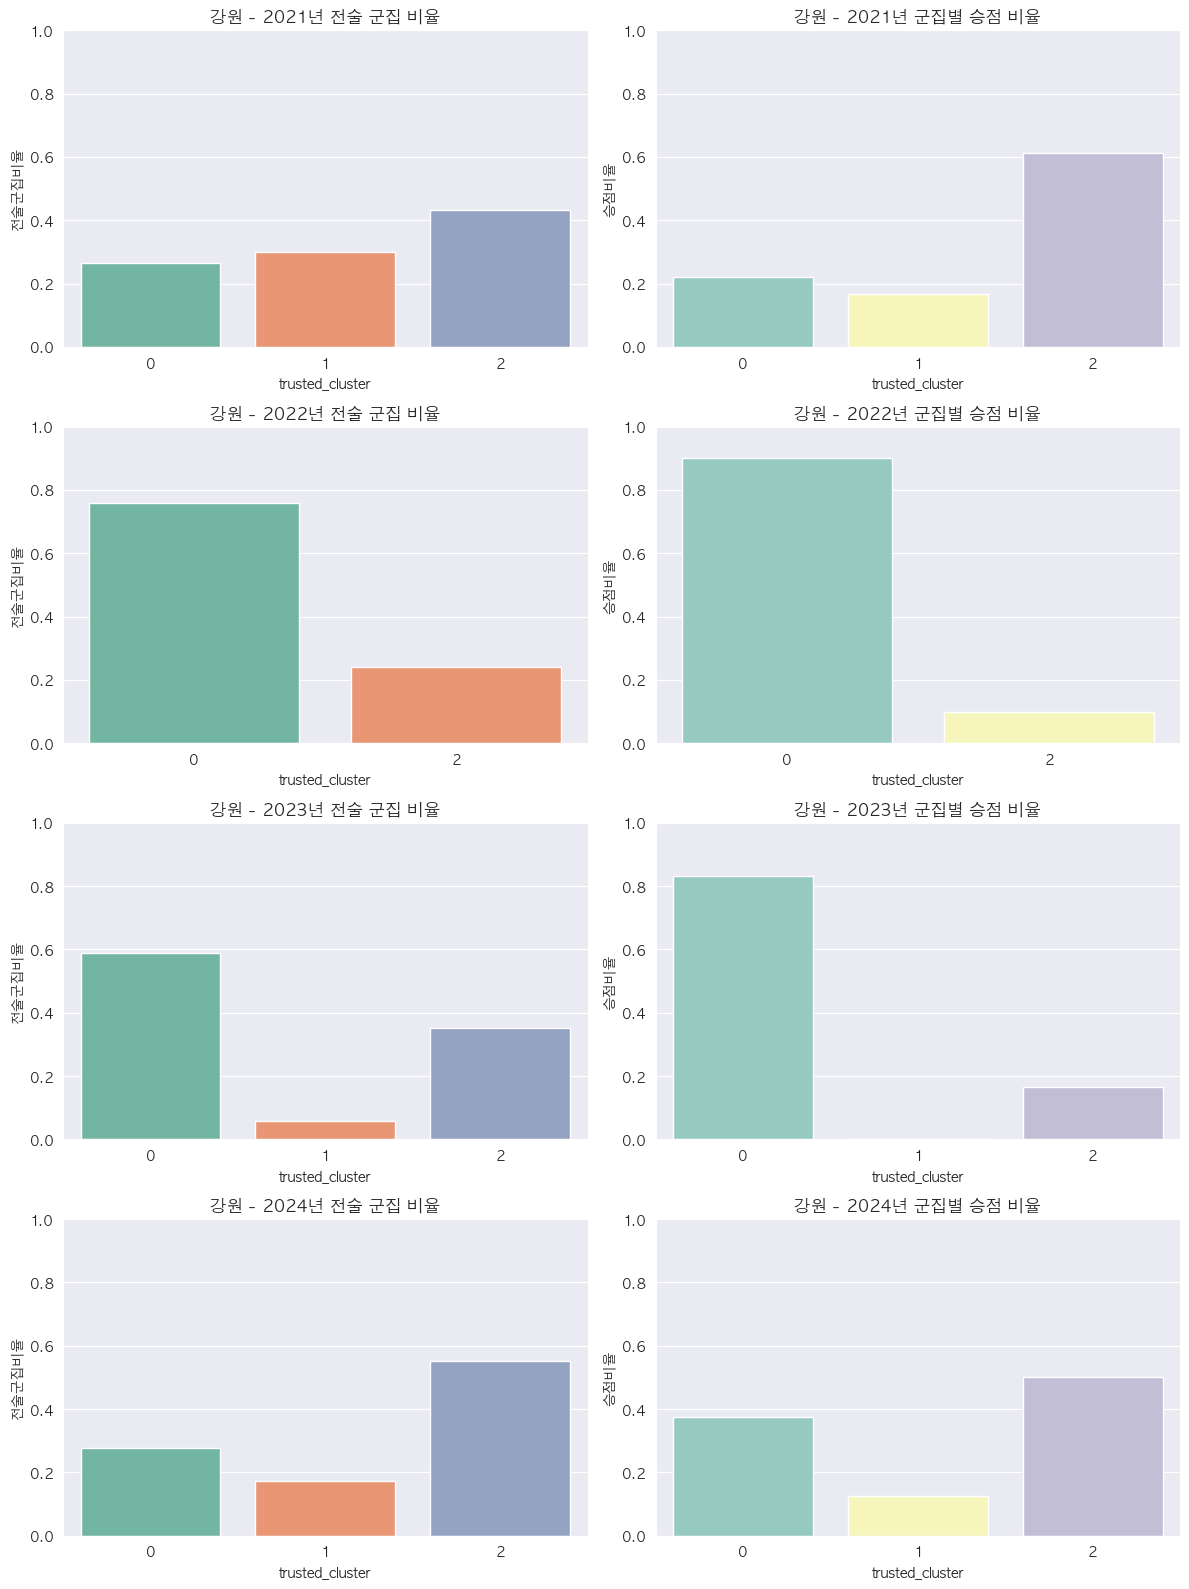

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

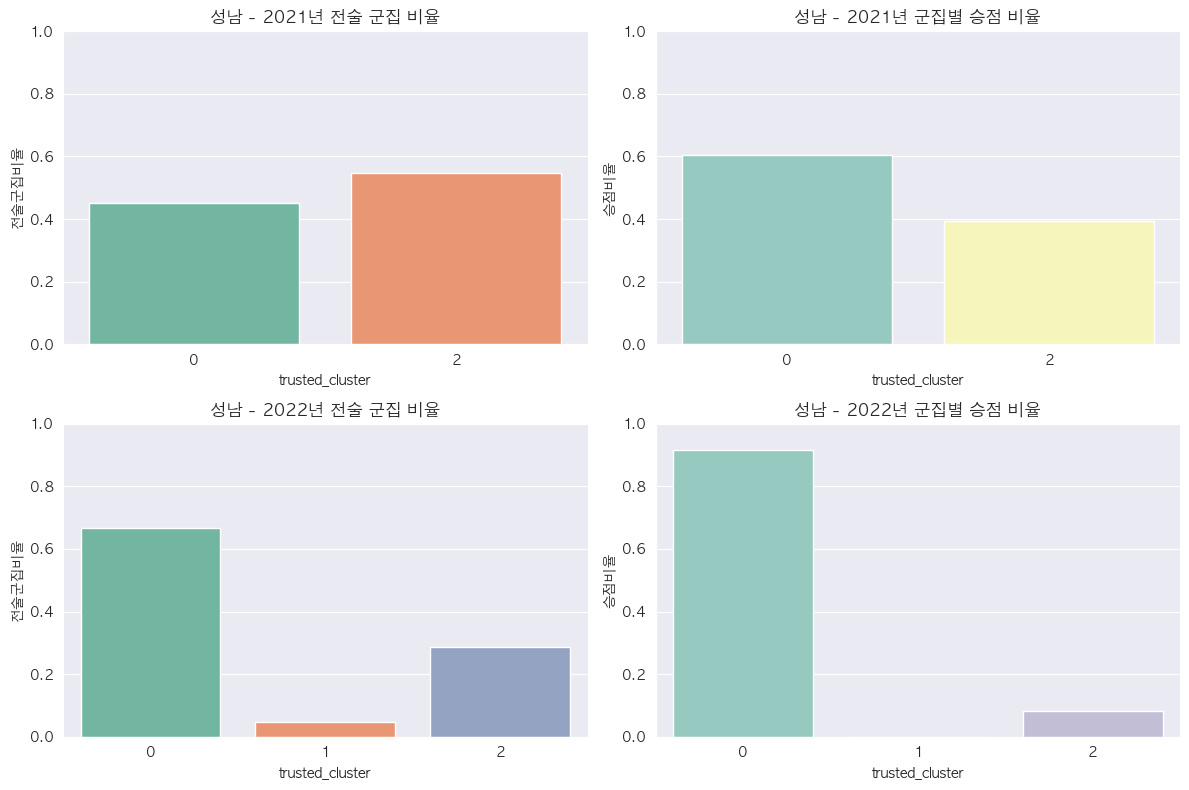

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

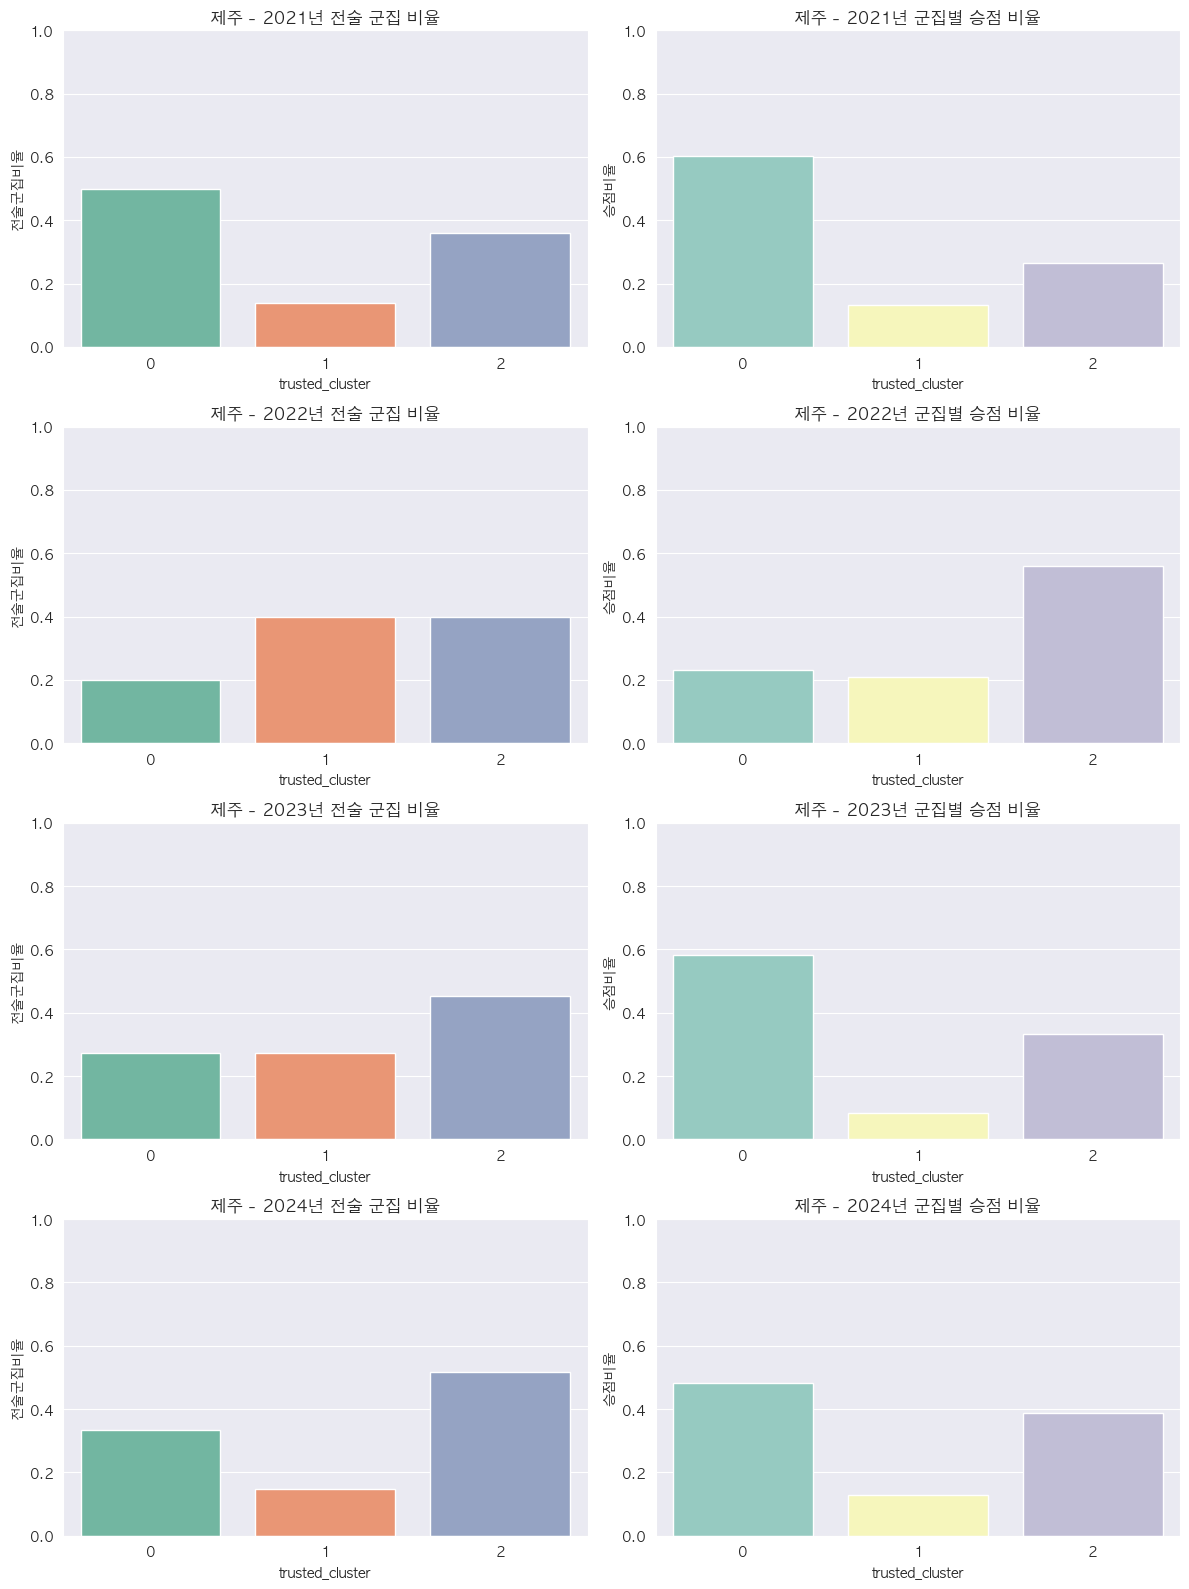

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

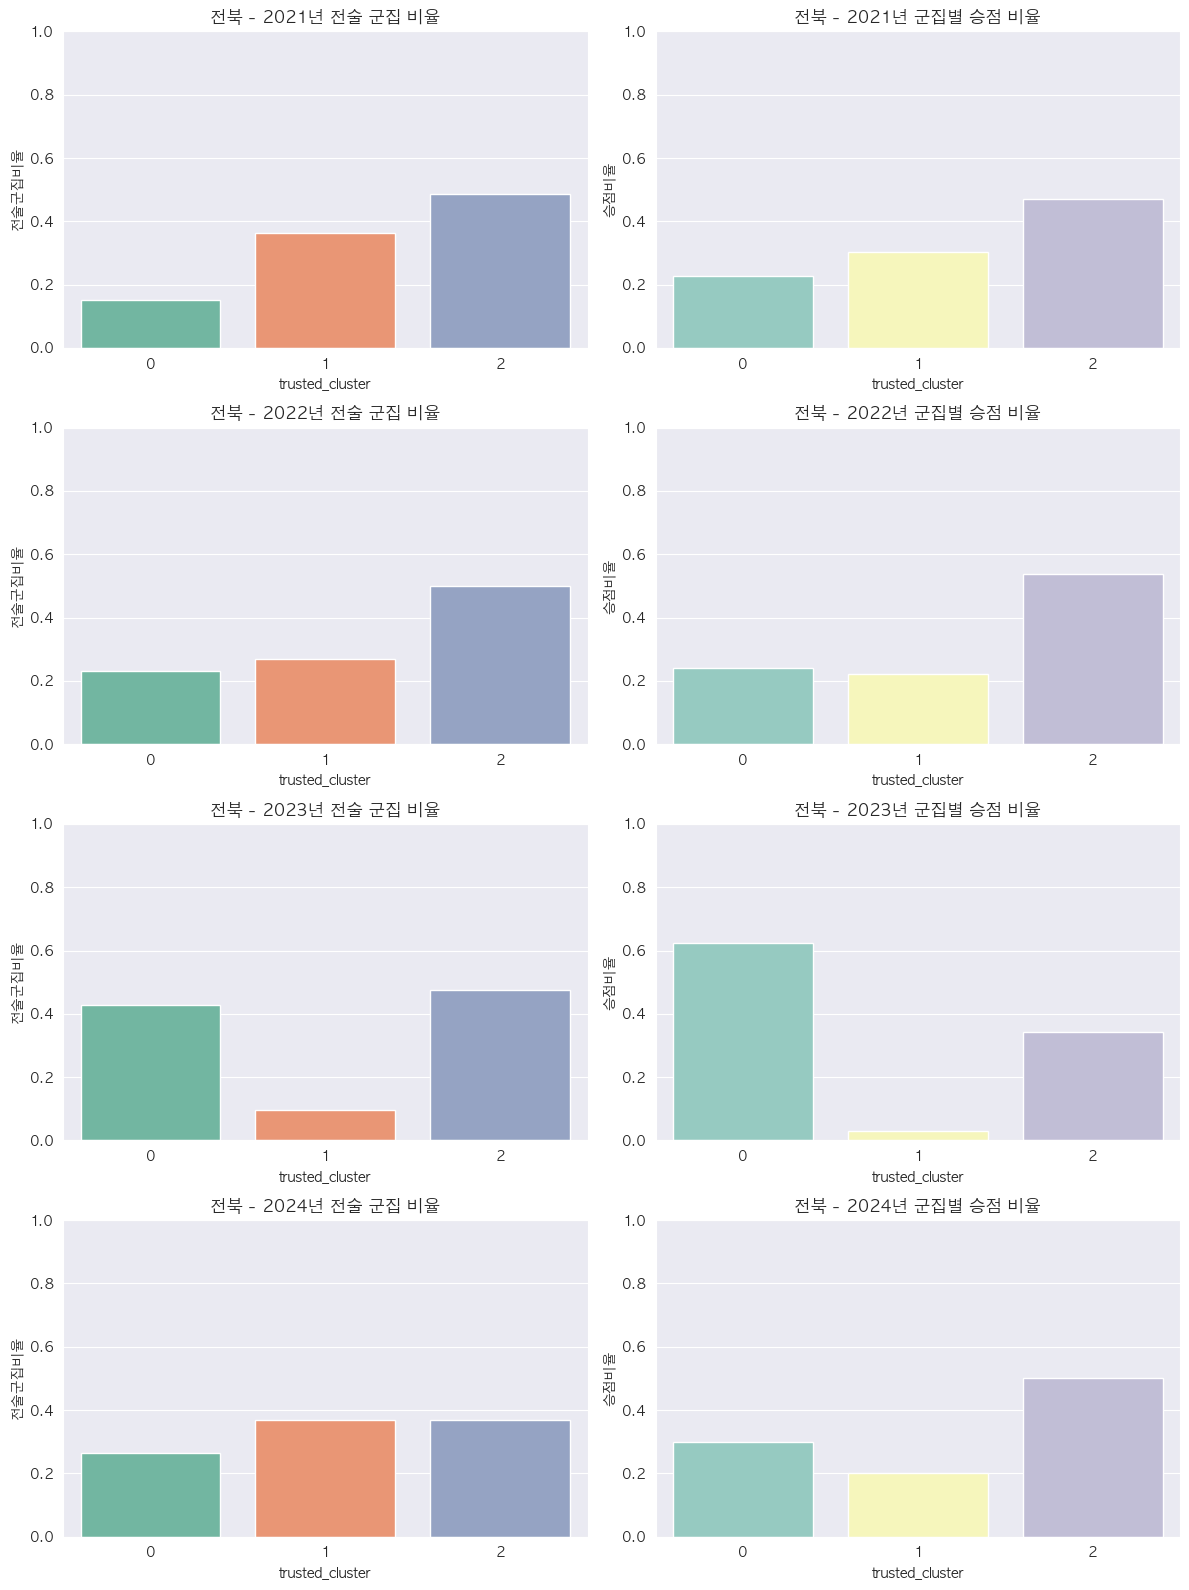

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

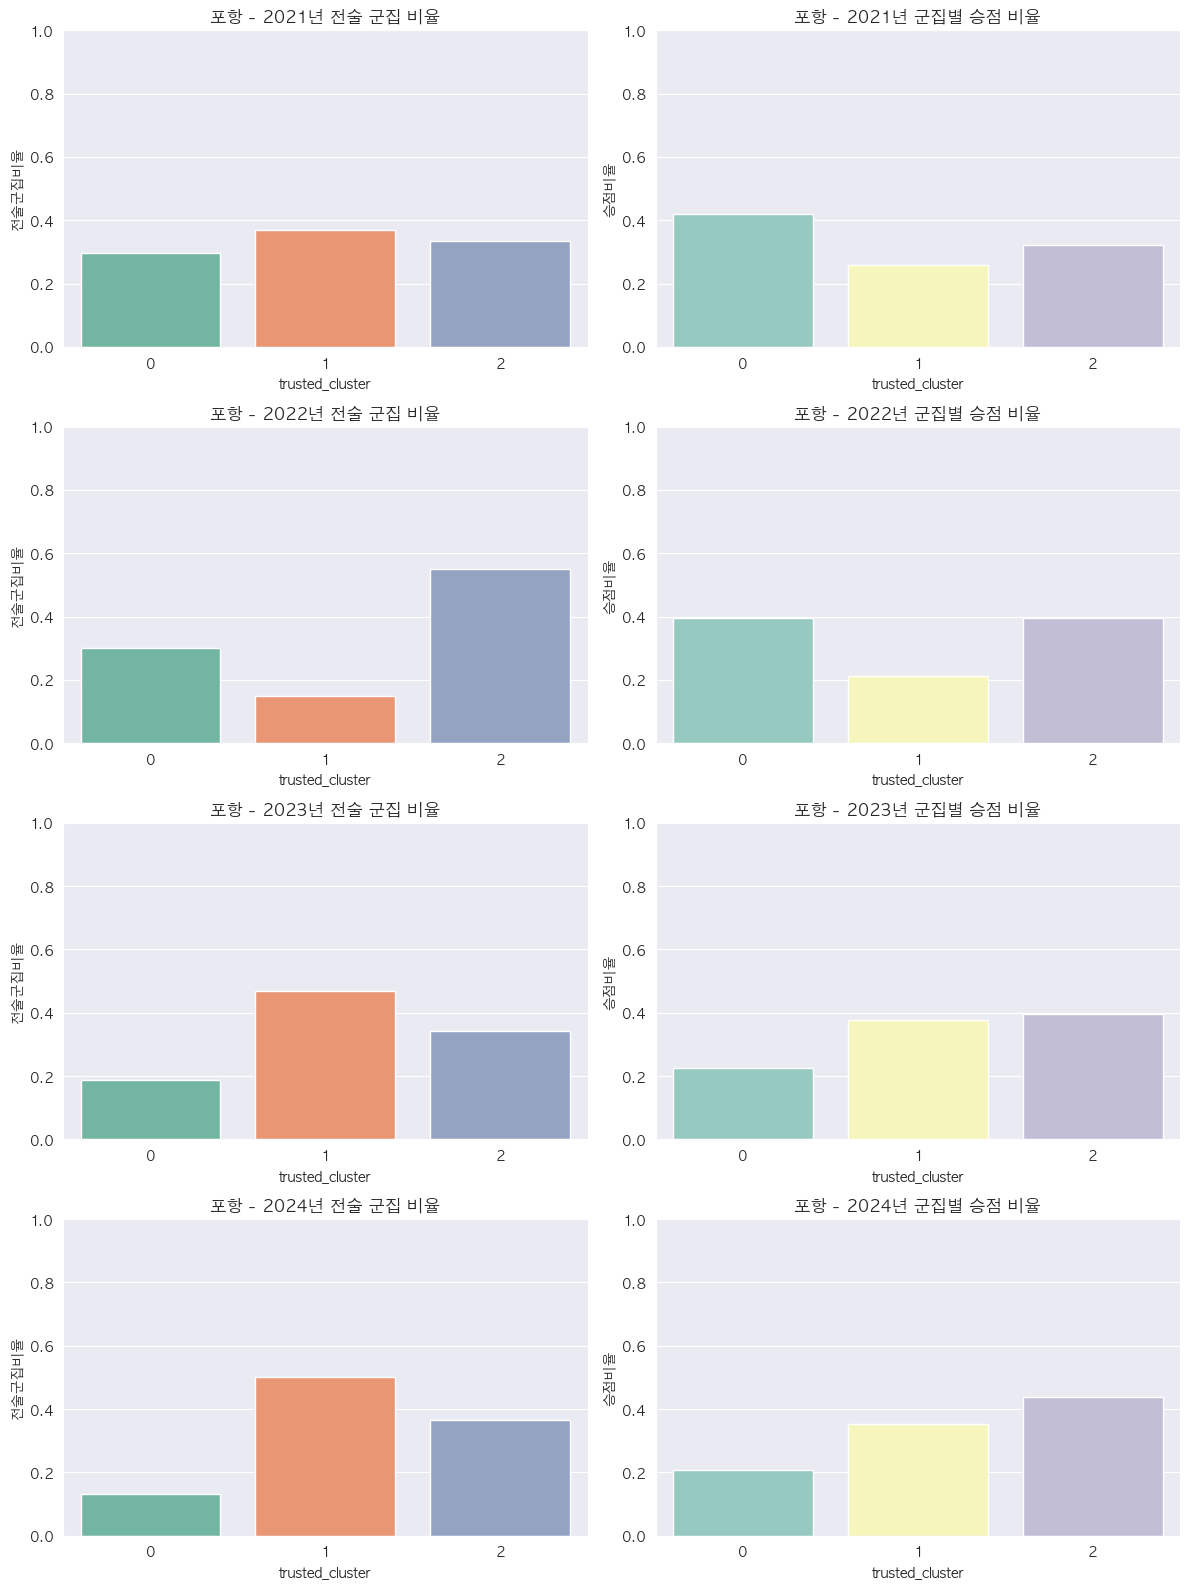

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

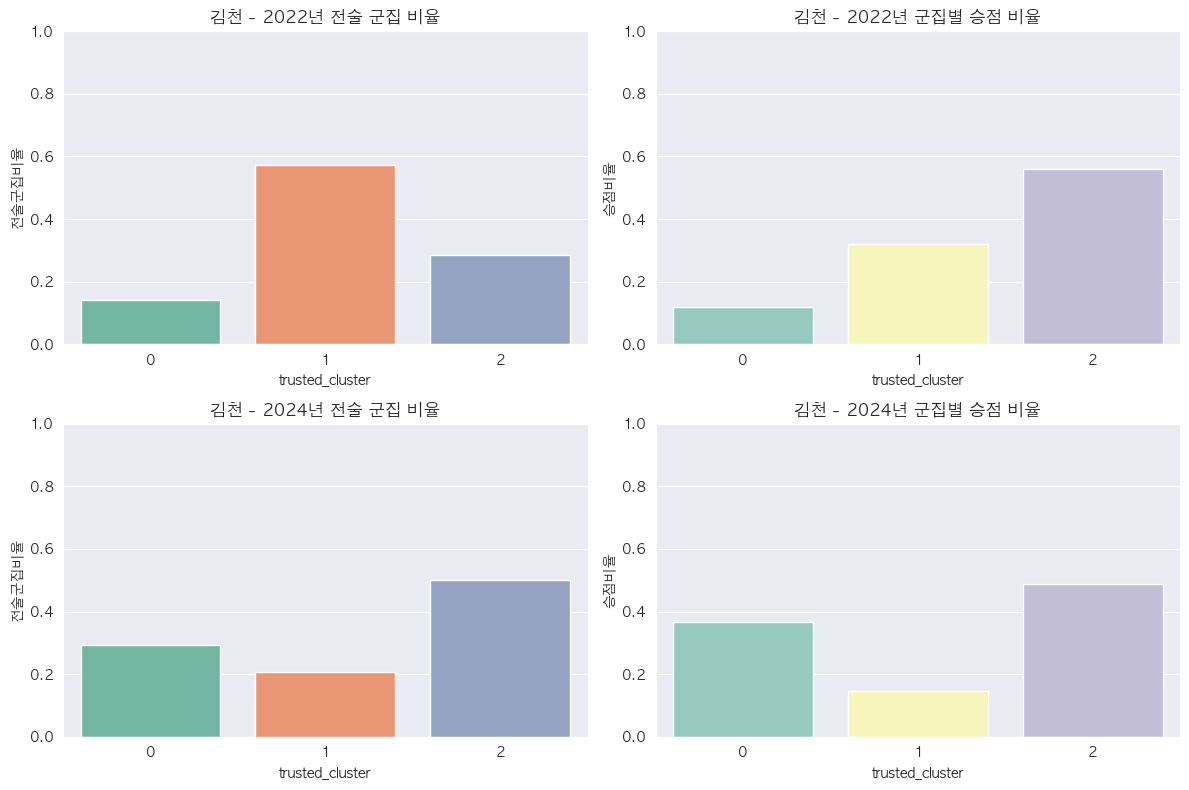

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/3028592986.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

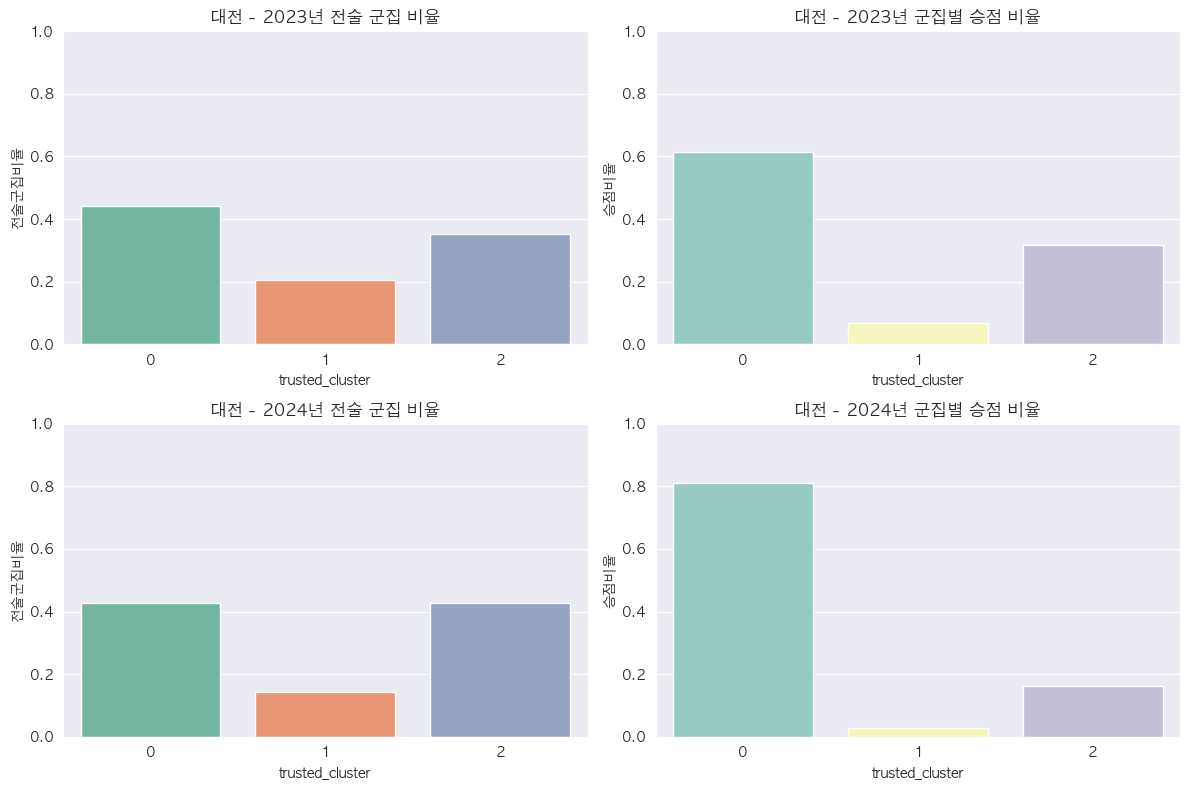

In [19]:
for team in filtered_df['구단'].unique():
    ratio_viz(team)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def ratio_viz_by_manager(team_name):
    team_df = filtered_df[filtered_df['구단'] == team_name].copy()

    # 전술 군집 비율
    tactical_ratio = (
        team_df.groupby(['년도', '감독', 'trusted_cluster'])
        .size()
        .reset_index(name='경기수')
    )
    tactical_ratio['전술군집비율'] = tactical_ratio.groupby(['년도', '감독'])['경기수'].transform(lambda x: x / x.sum())

    # 승점 비율
    tactical_ppm = (
        team_df.groupby(['년도', '감독', 'trusted_cluster'])['승점']
        .sum()
        .reset_index()
    )
    tactical_ppm['승점비율'] = tactical_ppm.groupby(['년도', '감독'])['승점'].transform(lambda x: x / x.sum())

    unique_groups = tactical_ratio[['년도', '감독']].drop_duplicates().sort_values(['년도', '감독'])
    num_groups = len(unique_groups)
    fig, axes = plt.subplots(num_groups, 2, figsize=(12, 4 * num_groups))

    if num_groups == 1:
        axes = [axes]

    for idx, (year, manager) in enumerate(unique_groups.values):
        # 왼쪽 그래프: 전술 군집 비율
        ax1 = axes[idx][0]
        plot_df_ratio = tactical_ratio[(tactical_ratio['년도'] == year) & (tactical_ratio['감독'] == manager)]
        sns.barplot(
            data=plot_df_ratio,
            x='trusted_cluster', y='전술군집비율', ax=ax1, palette='Set2'
        )
        ax1.set_title(f'{team_name} - {year}년 {manager} 감독의 전술 군집 비율')
        ax1.set_ylim(0, 1)

        # 수치 표시 (경기수)
        for i, row in plot_df_ratio.iterrows():
            ax1.text(
                x=i - plot_df_ratio.index[0],  # 인덱스 보정
                y=row['전술군집비율'] + 0.02,
                s=f"{int(row['경기수'])}경기",
                ha='center', va='bottom', fontsize=9
            )

        # 오른쪽 그래프: 승점 비율
        ax2 = axes[idx][1]
        plot_df_ppm = tactical_ppm[(tactical_ppm['년도'] == year) & (tactical_ppm['감독'] == manager)]
        sns.barplot(
            data=plot_df_ppm,
            x='trusted_cluster', y='승점비율', ax=ax2, palette='Set3'
        )
        ax2.set_title(f'{team_name} - {year}년 {manager} 감독의 군집별 승점 기여')
        ax2.set_ylim(0, 1)

        # 수치 표시 (승점)
        for i, row in plot_df_ppm.iterrows():
            ax2.text(
                x=i - plot_df_ppm.index[0],
                y=row['승점비율'] + 0.02,
                s=f"{row['승점']}점",
                ha='center', va='bottom', fontsize=9
            )

    plt.tight_layout()
    plt.show()


/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

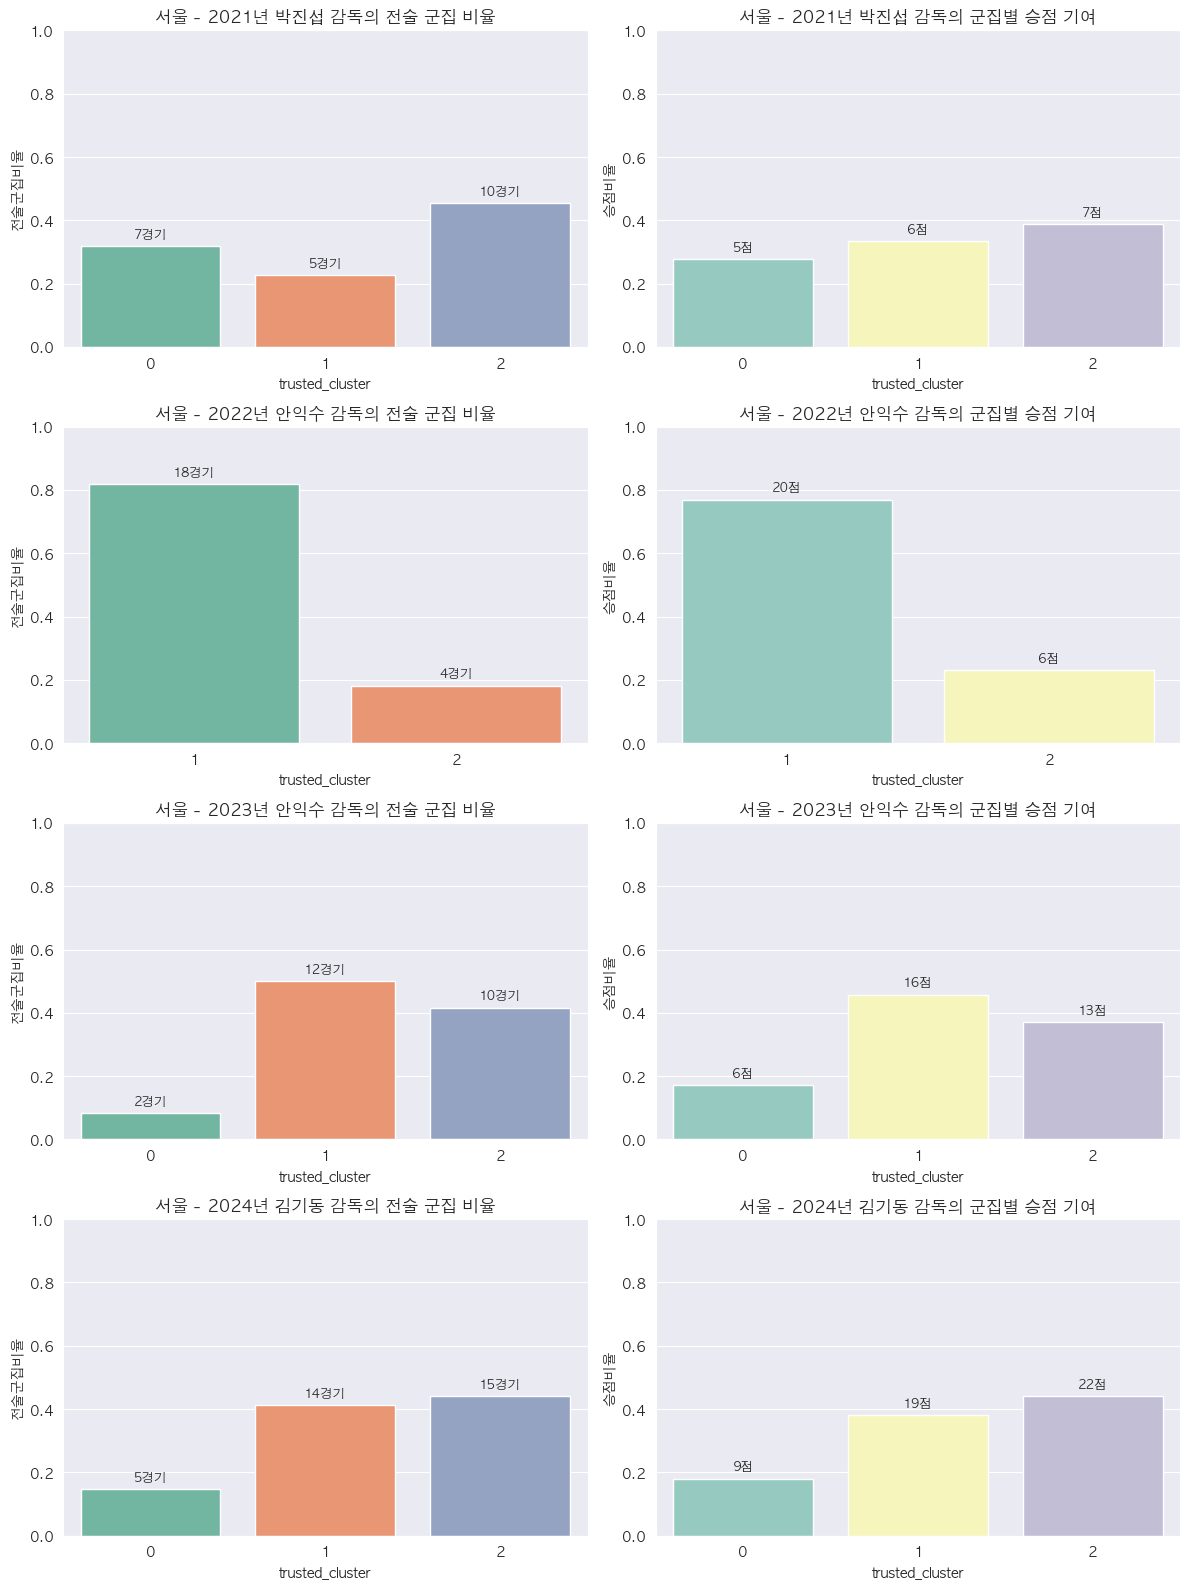

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

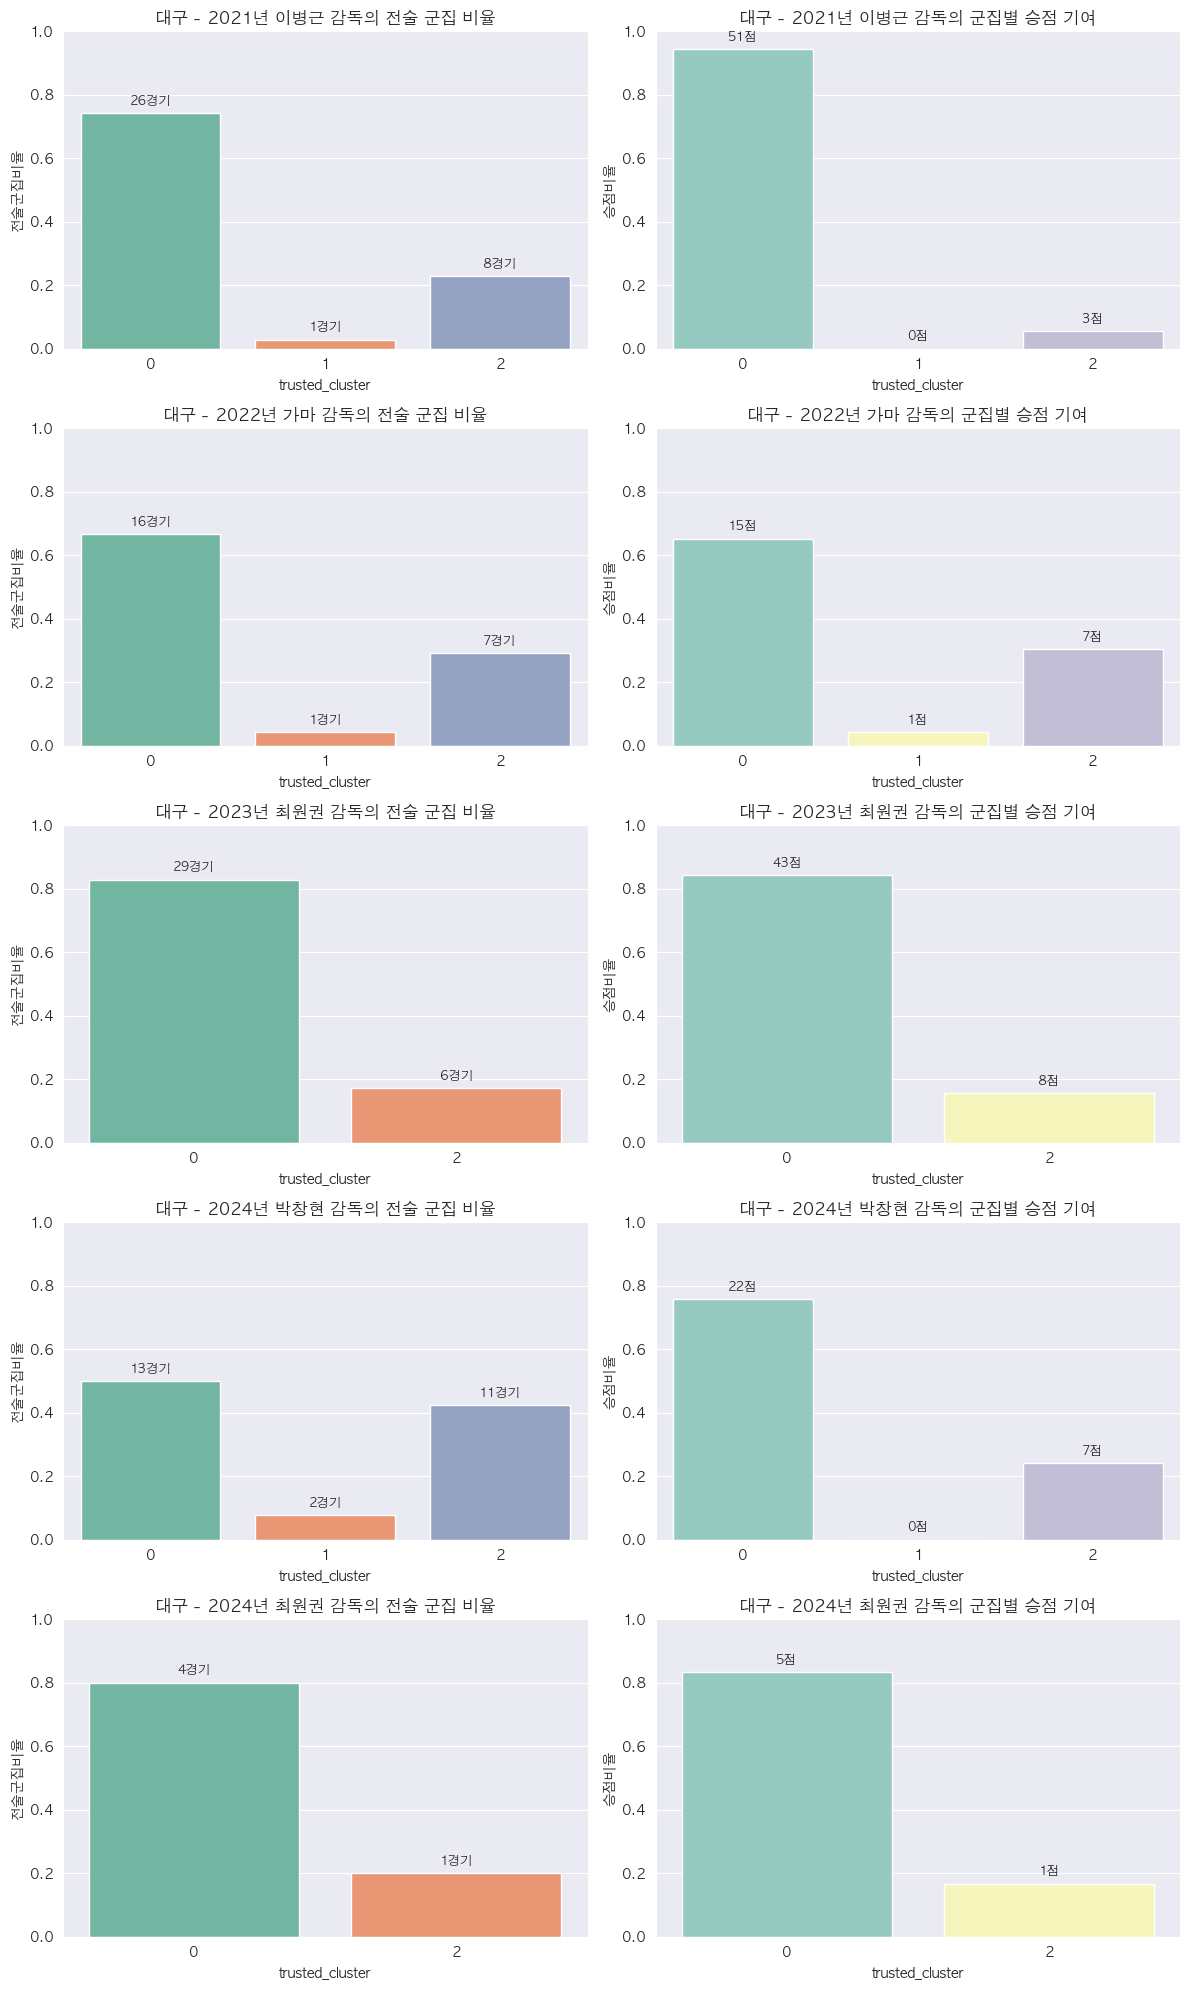

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

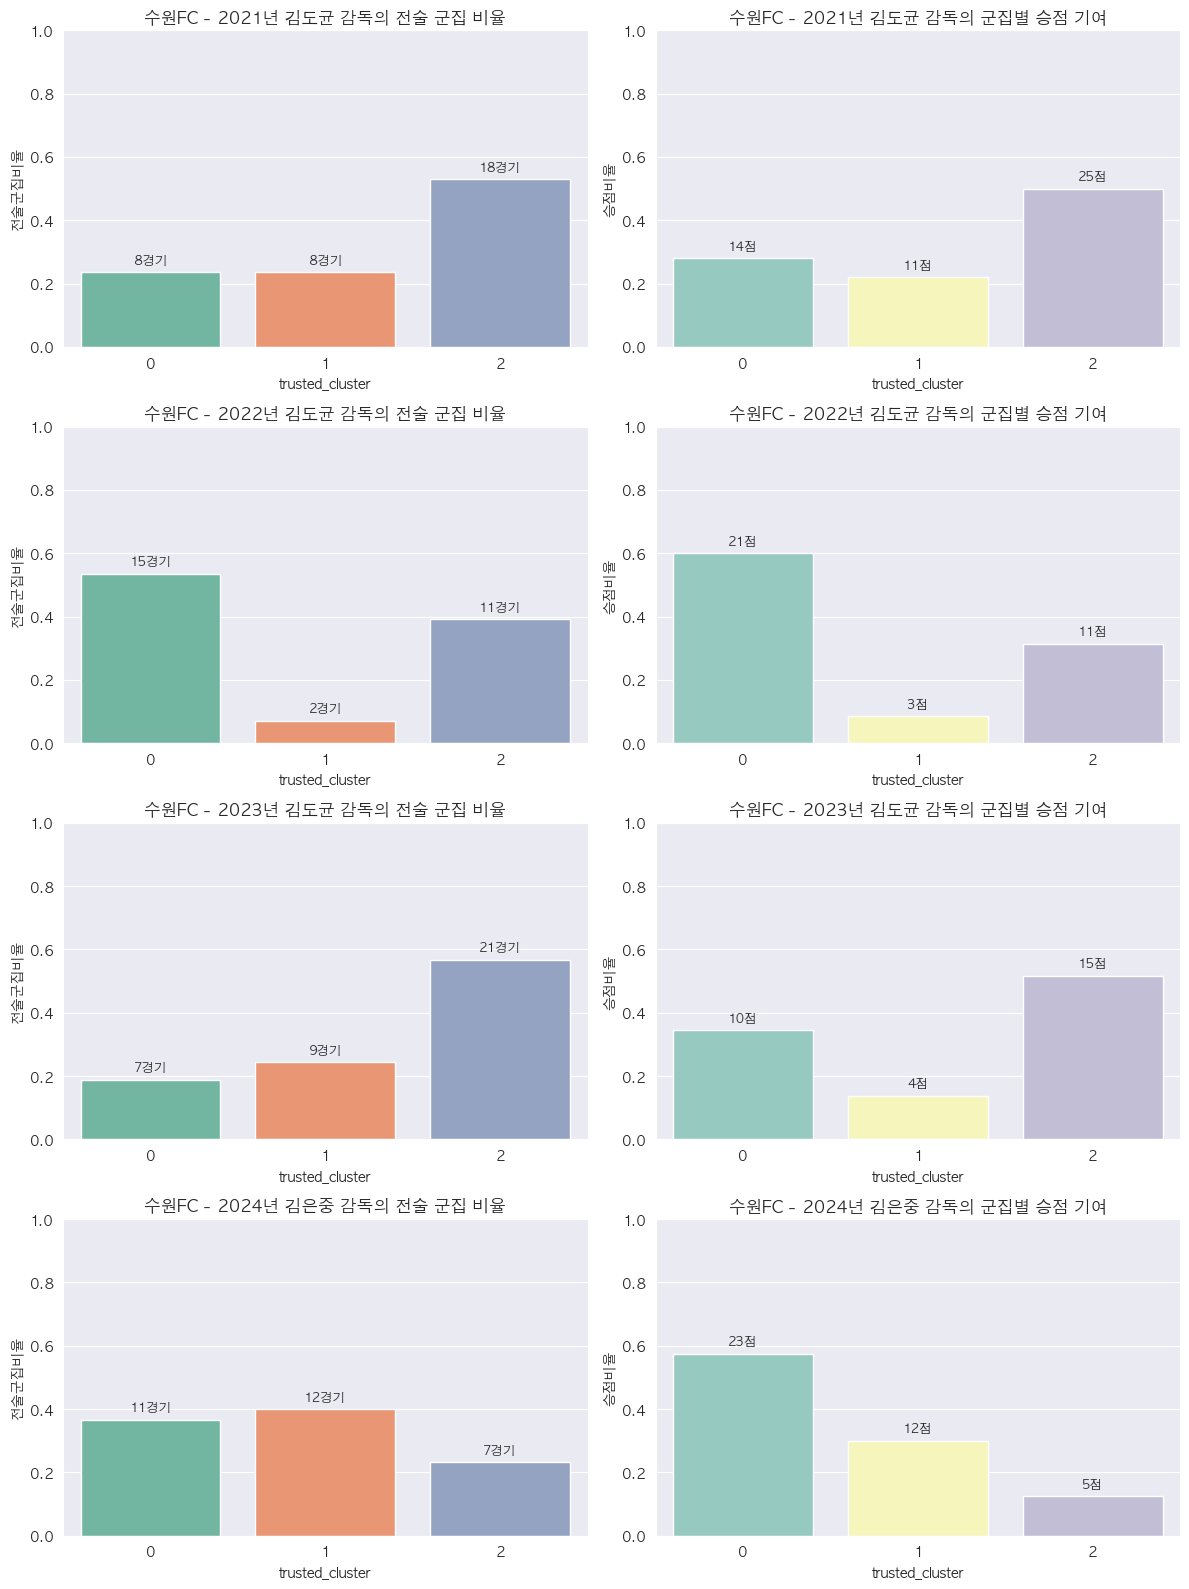

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

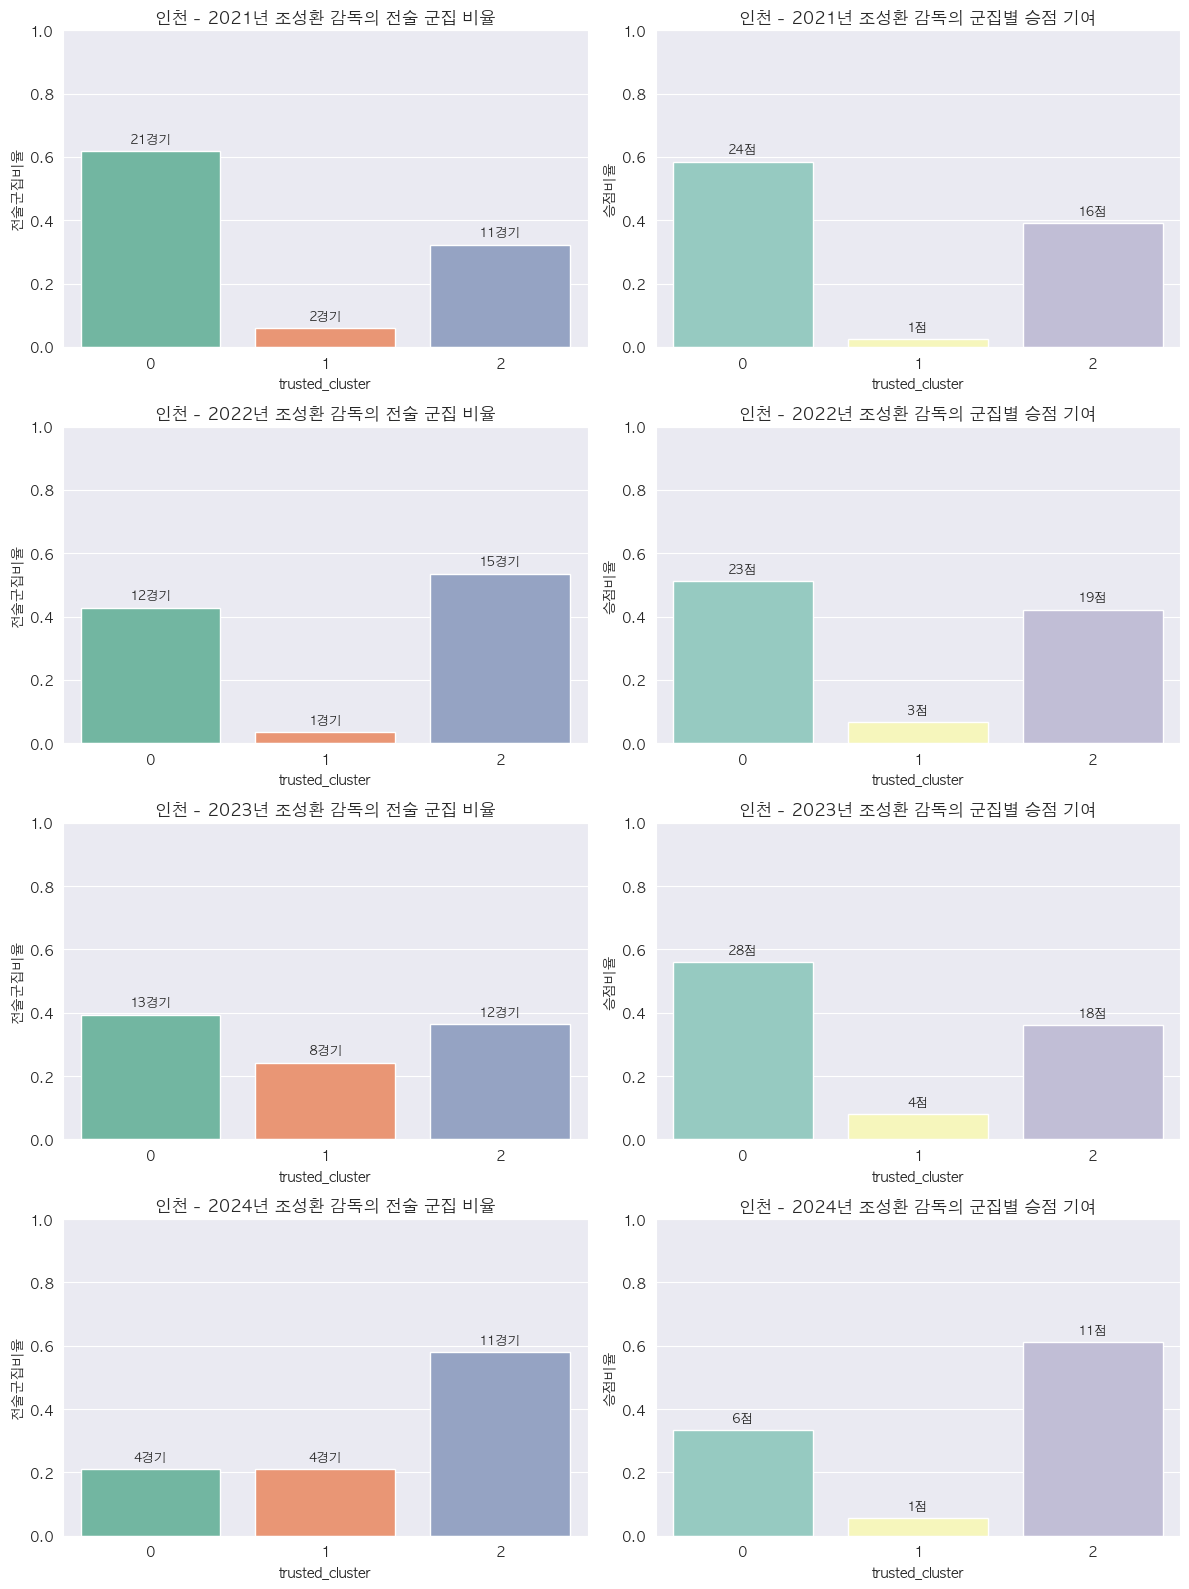

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

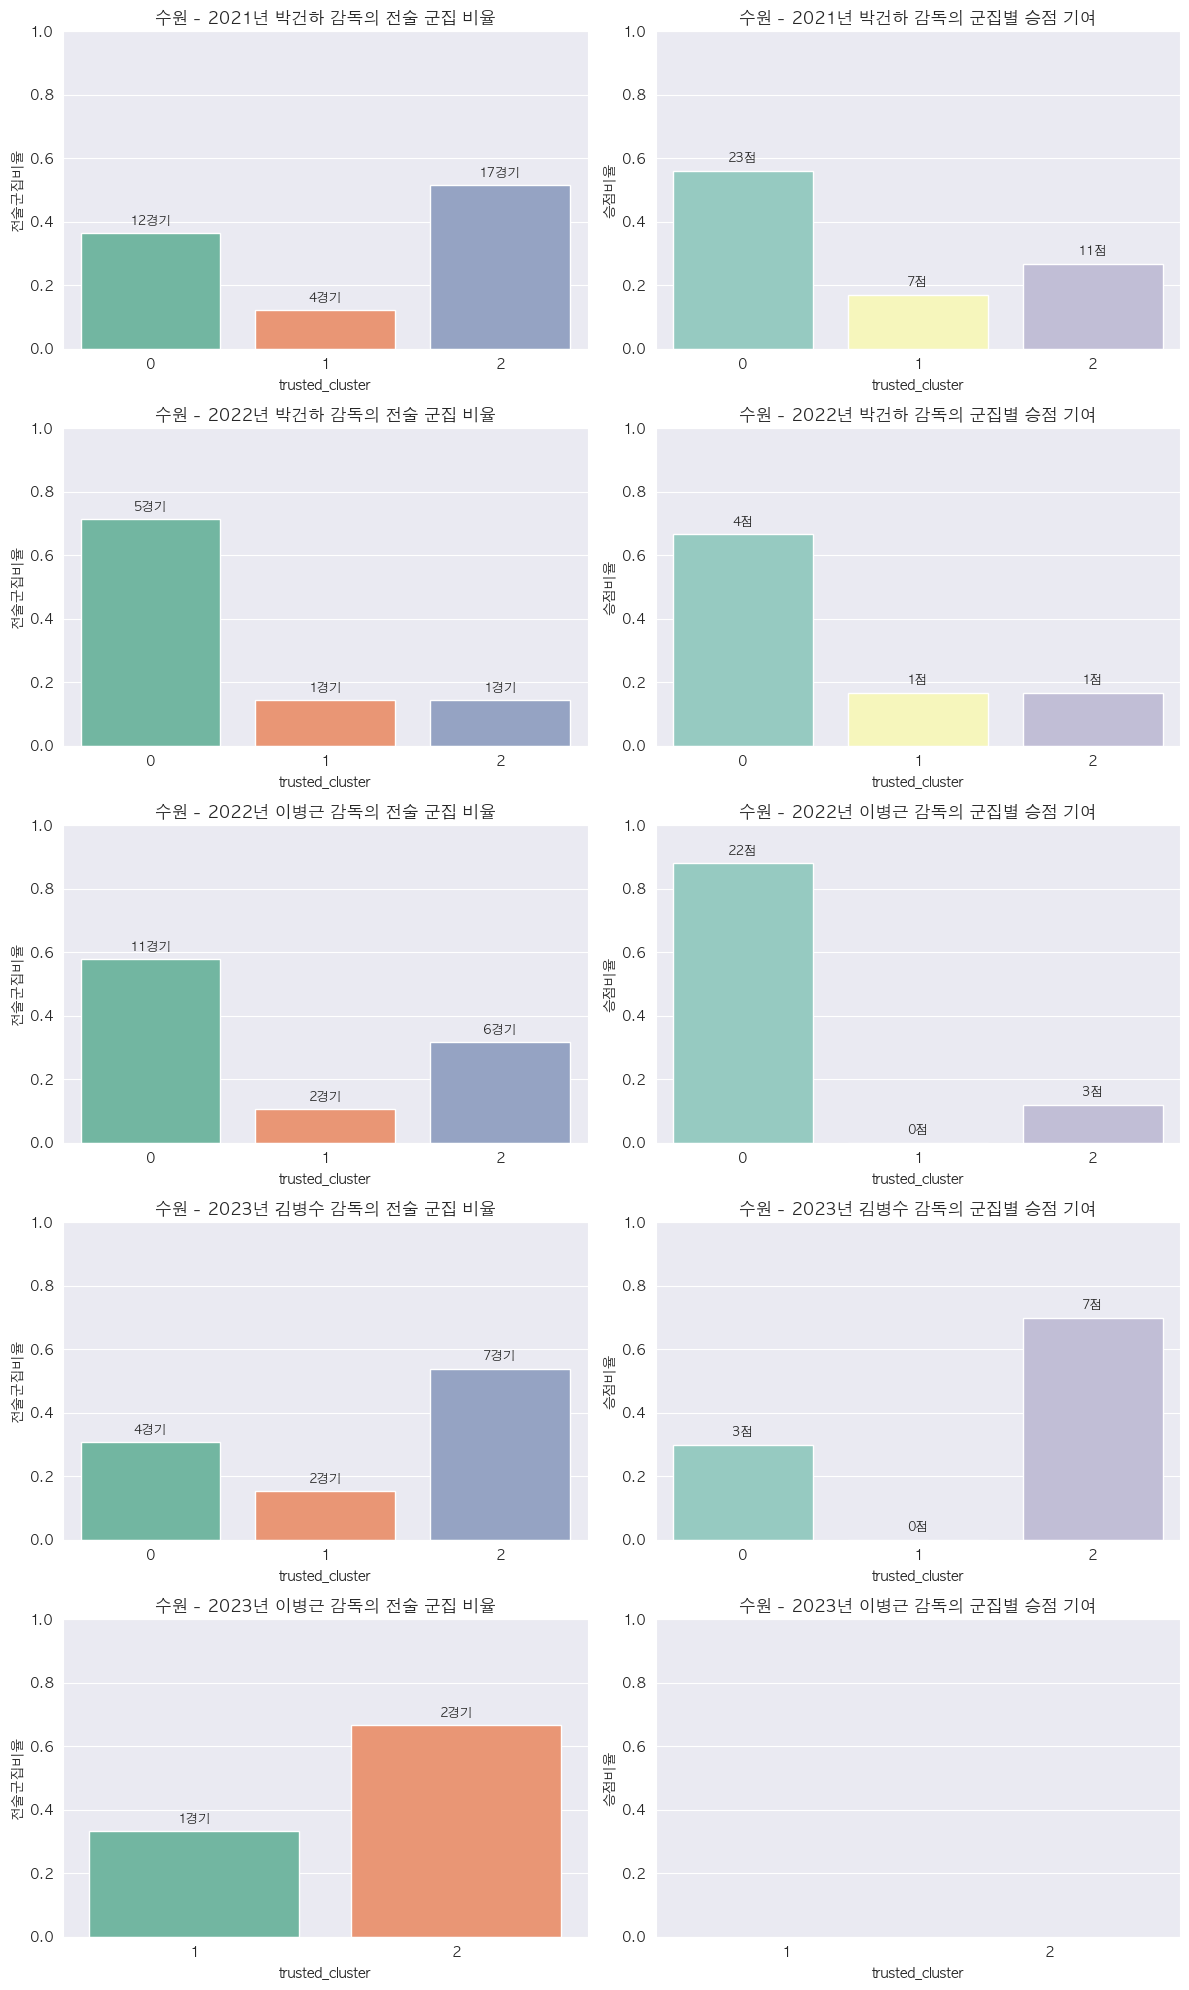

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

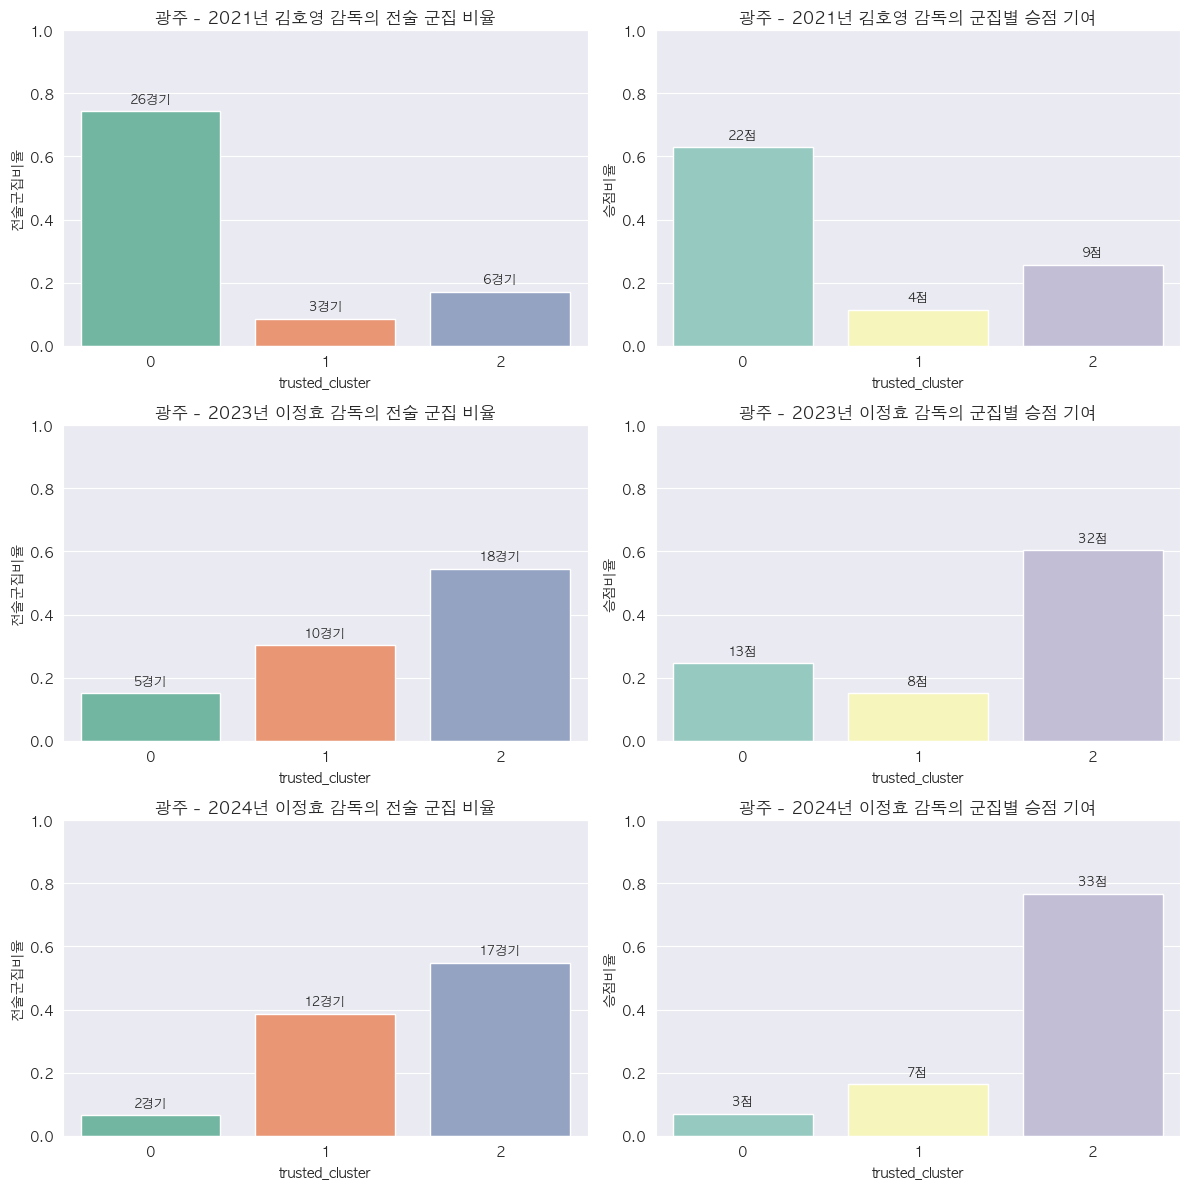

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

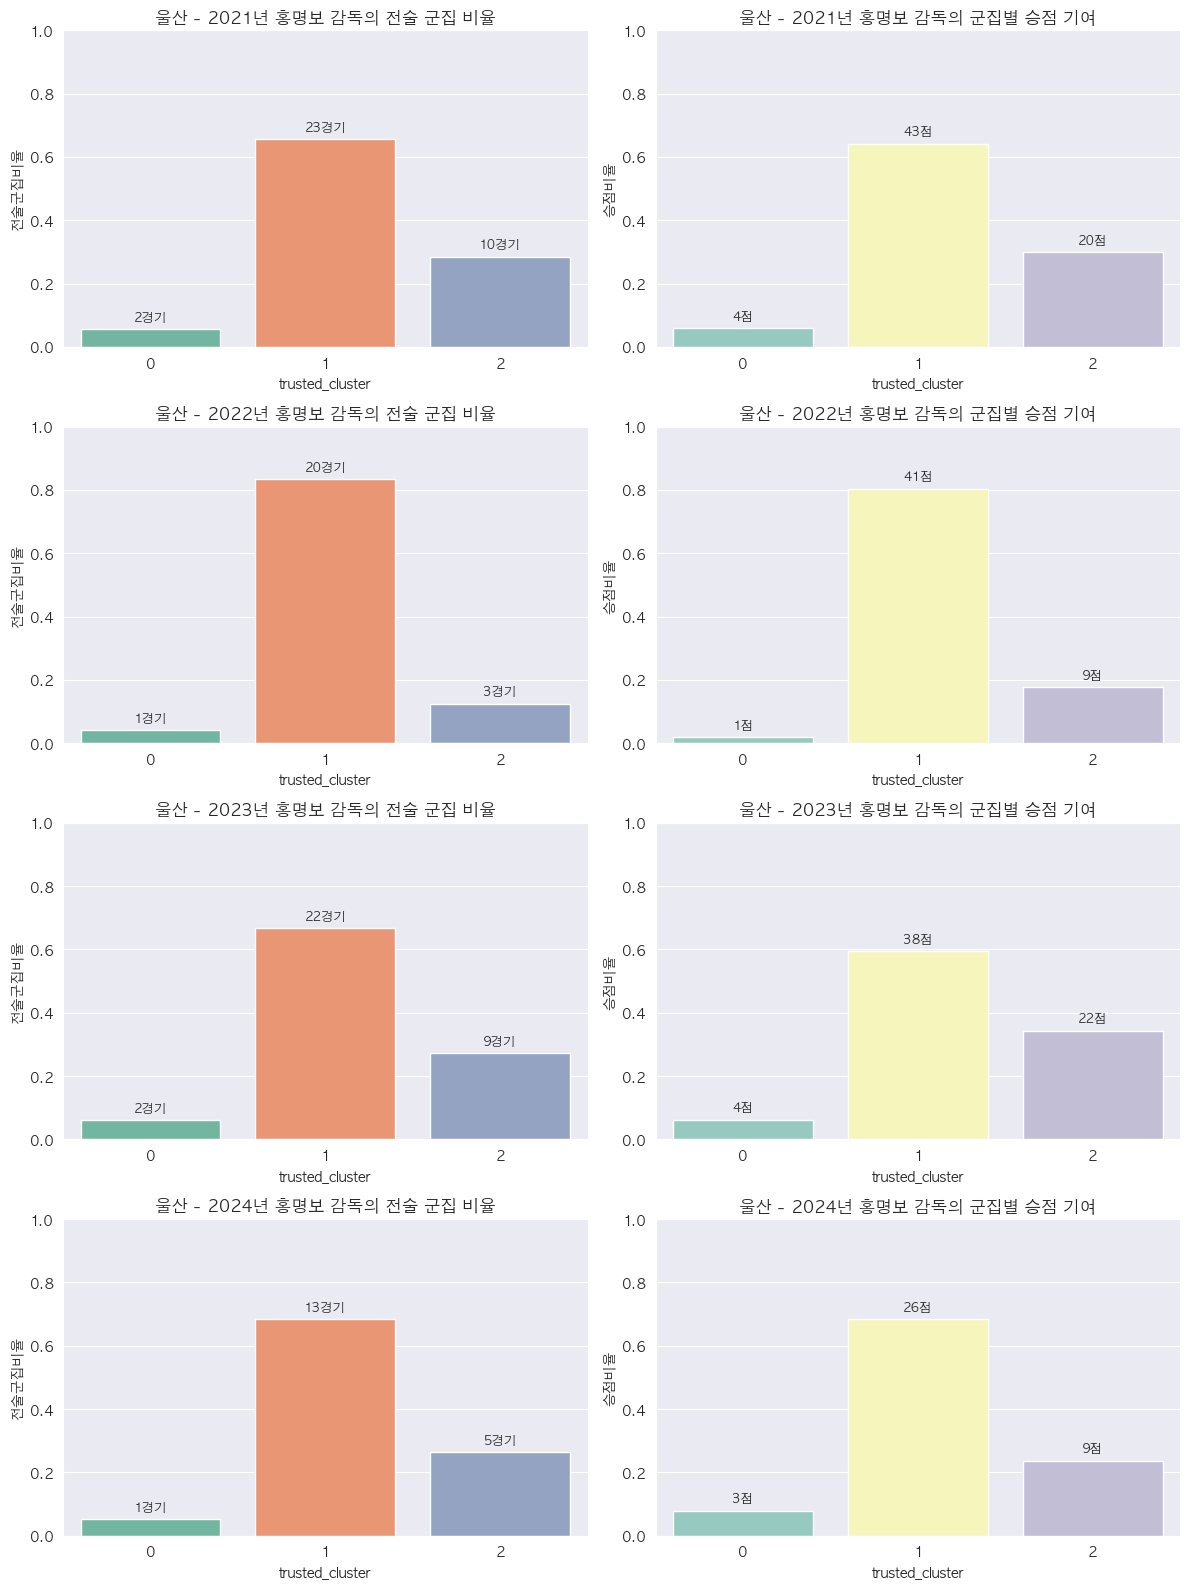

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

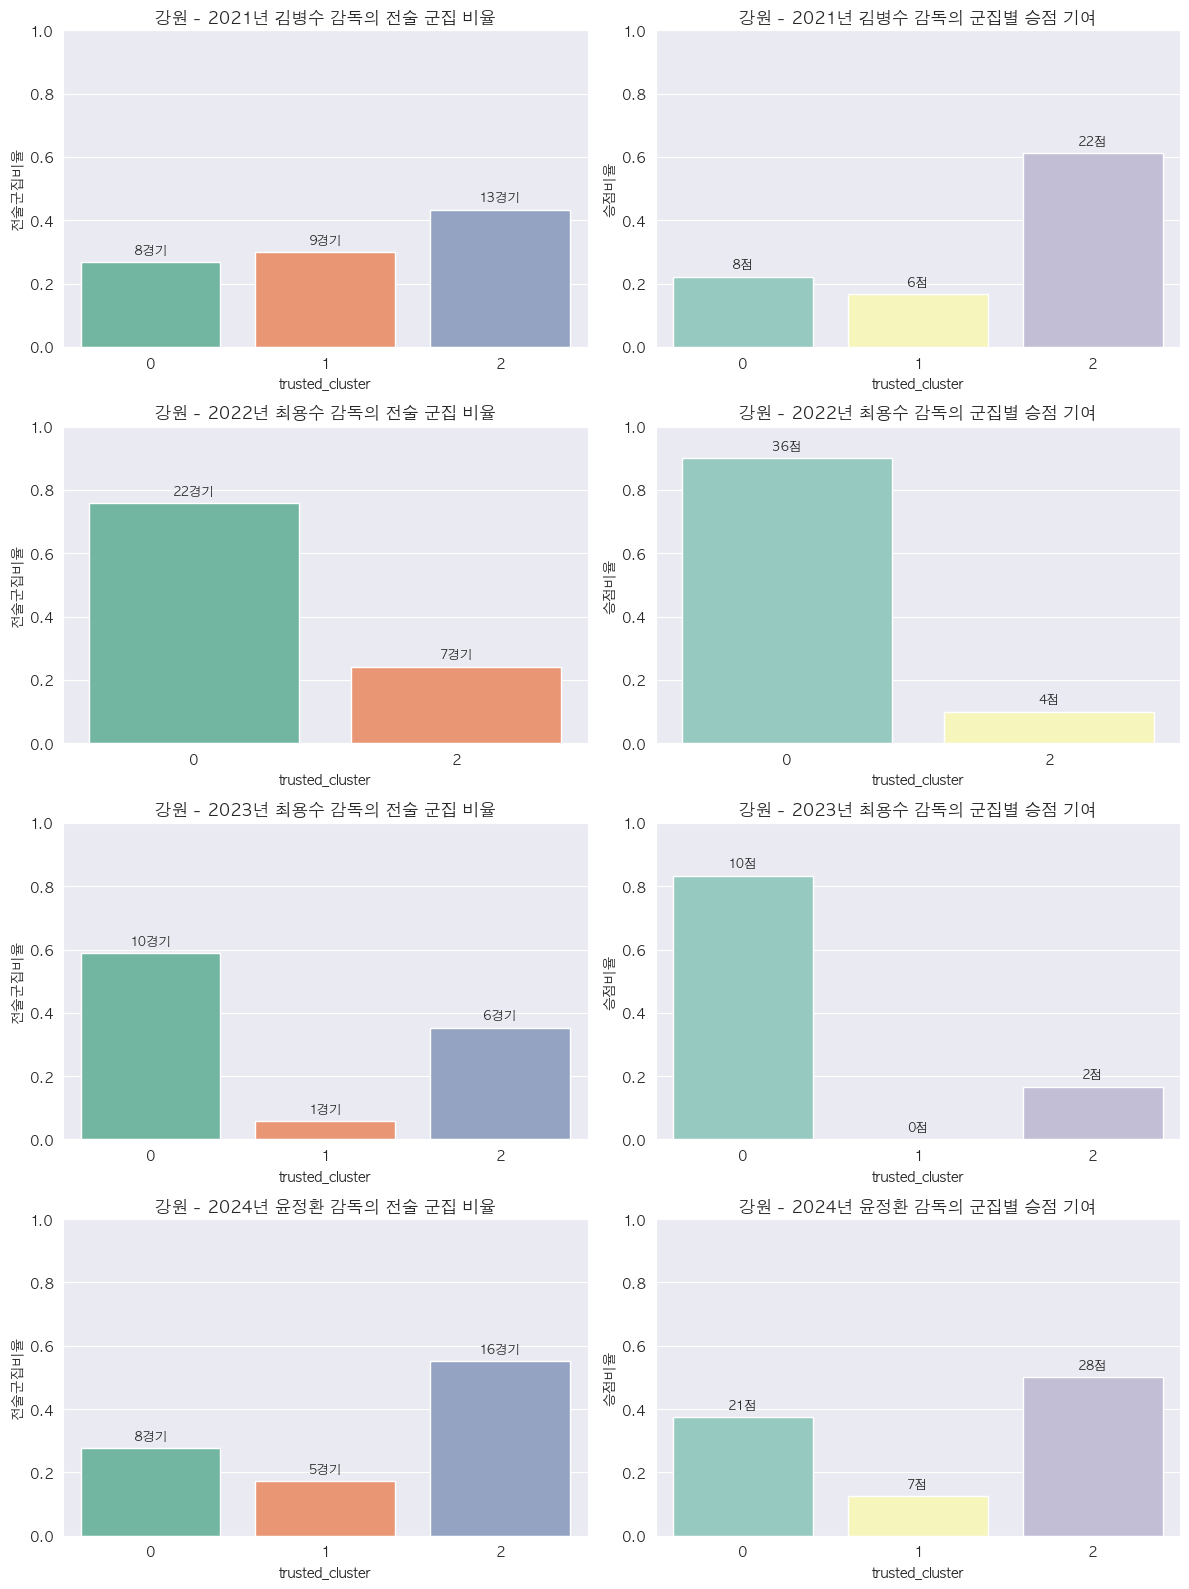

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

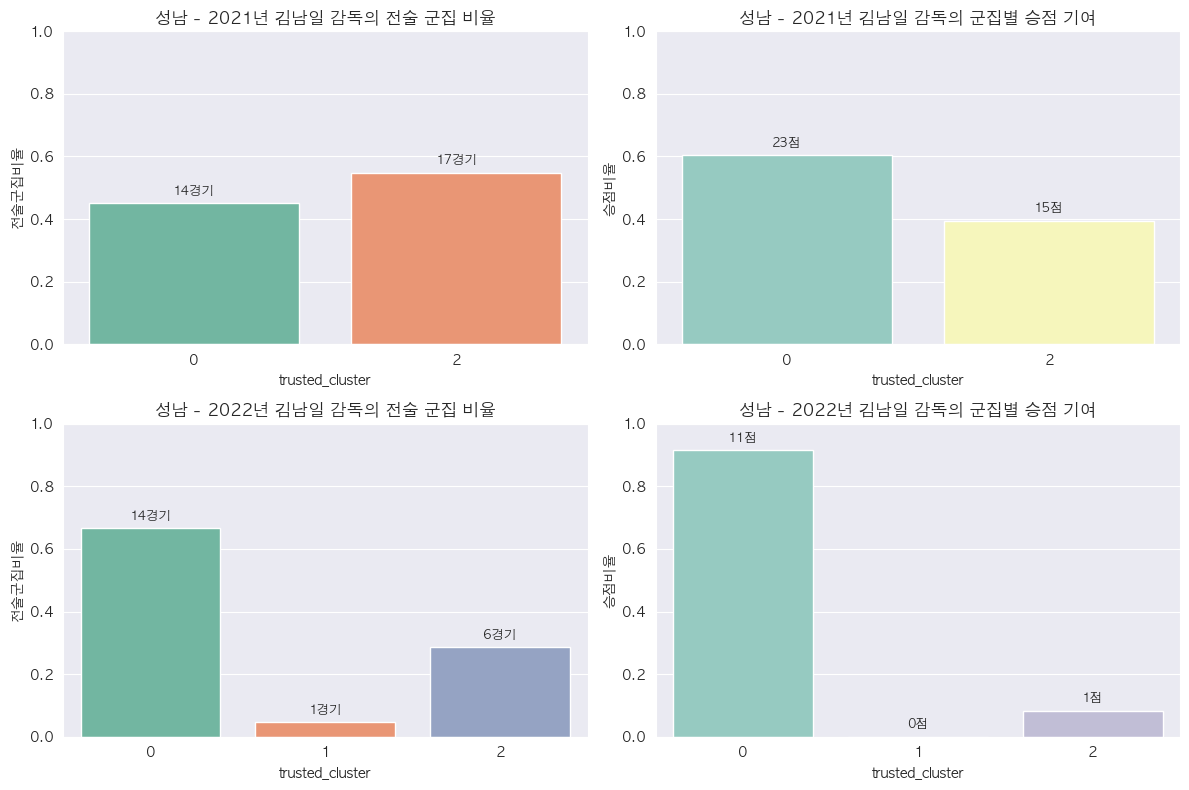

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

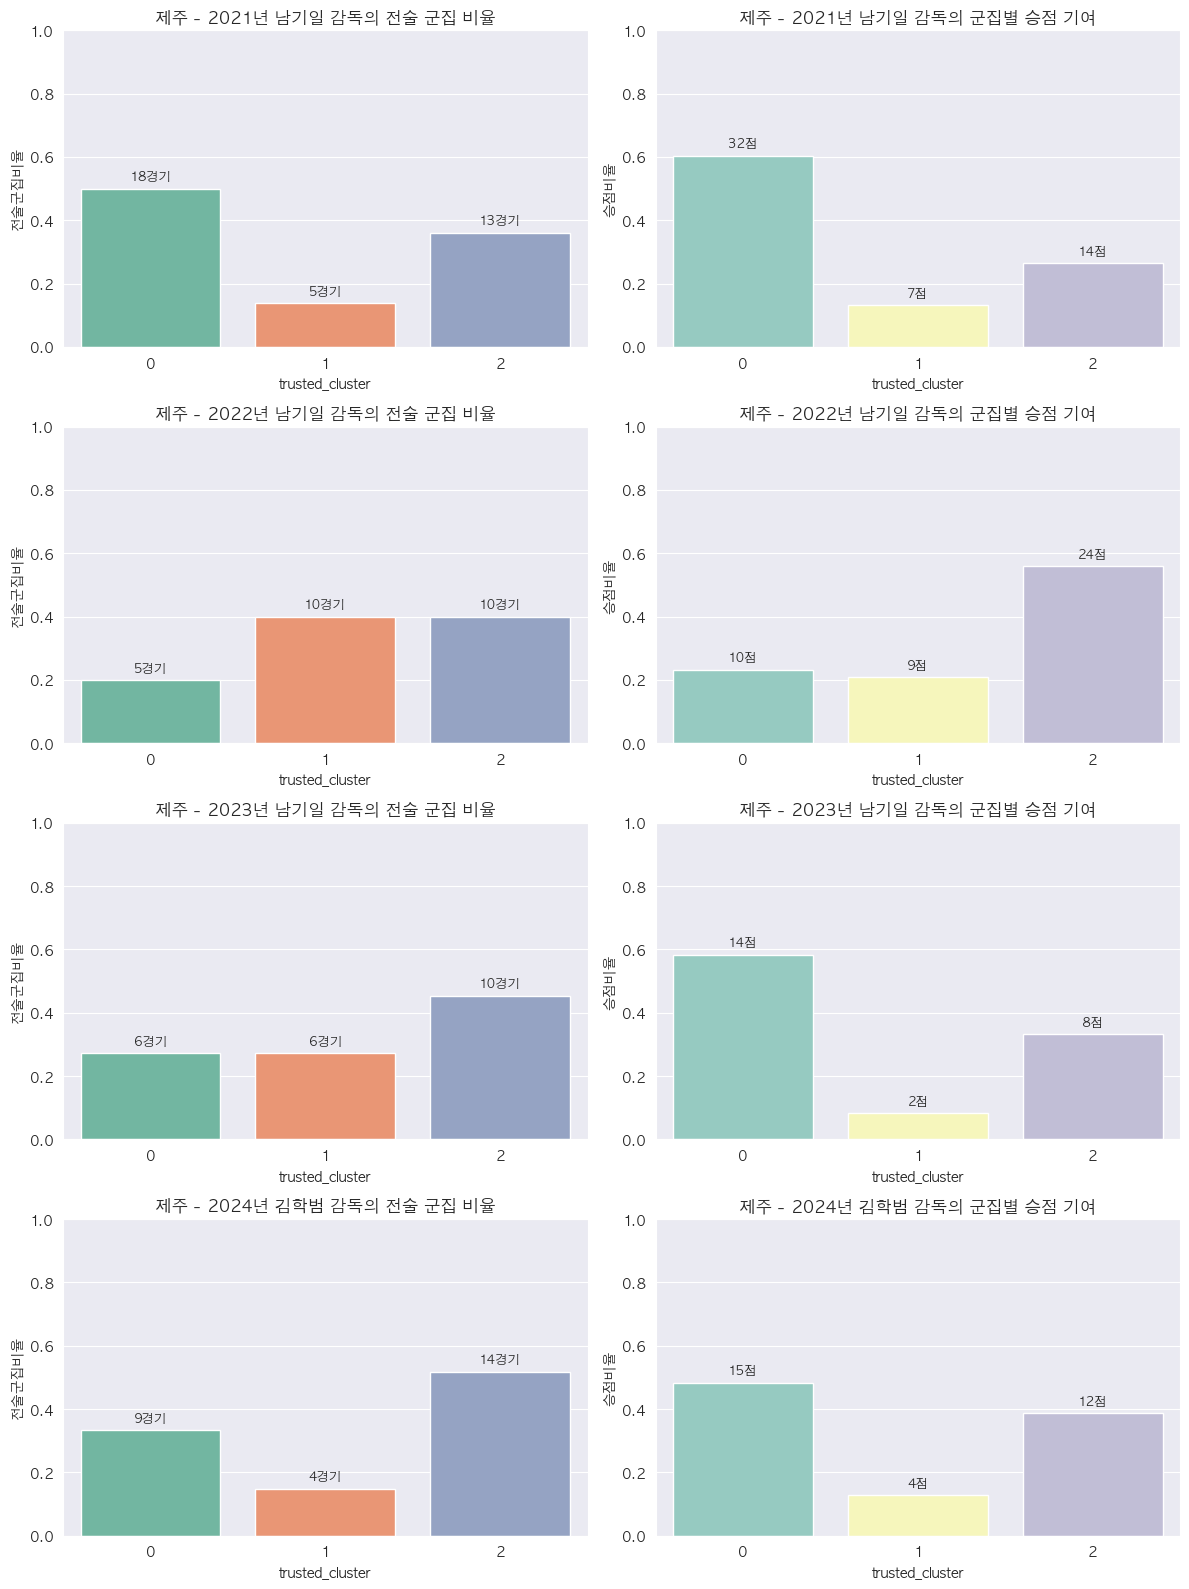

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

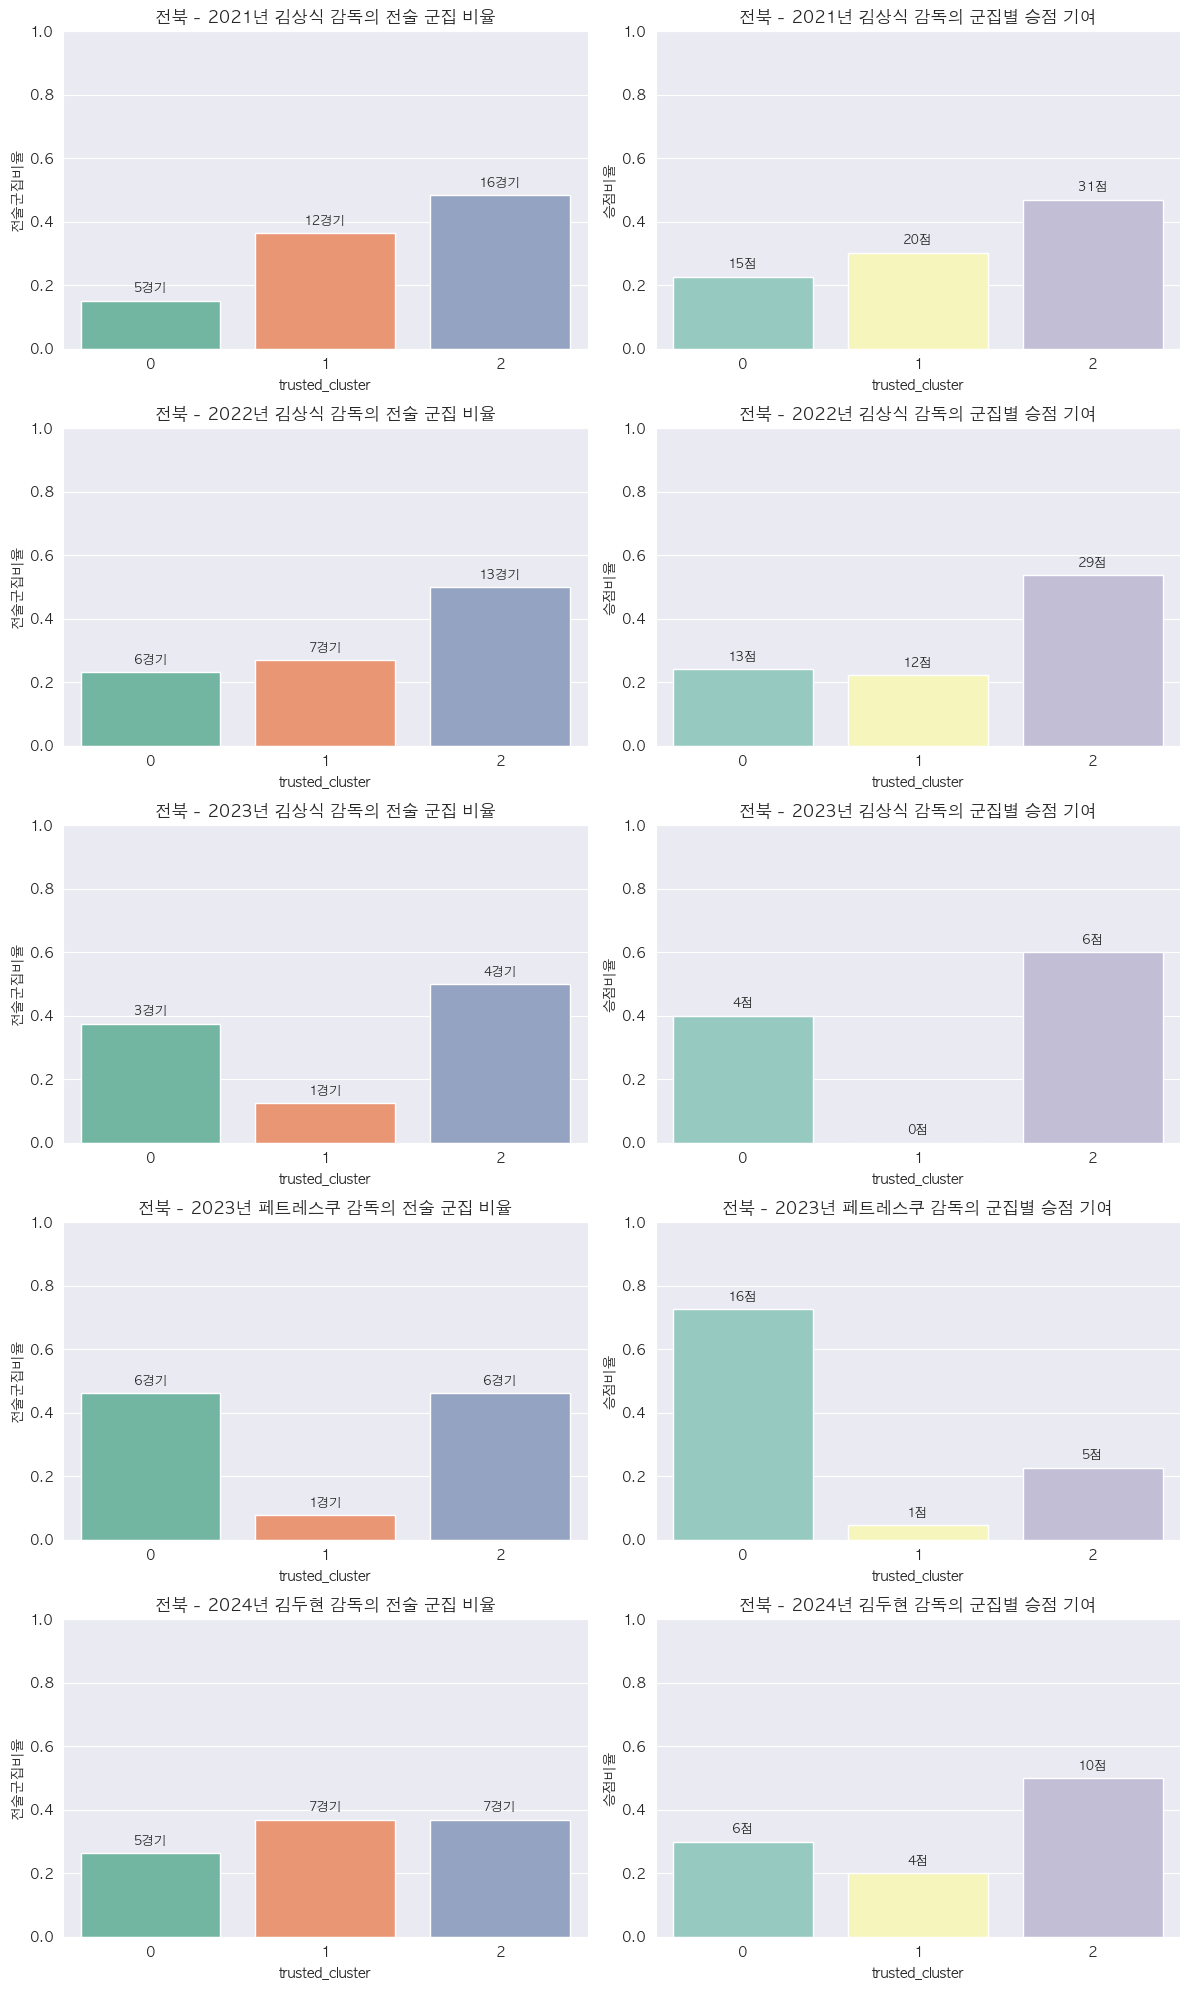

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

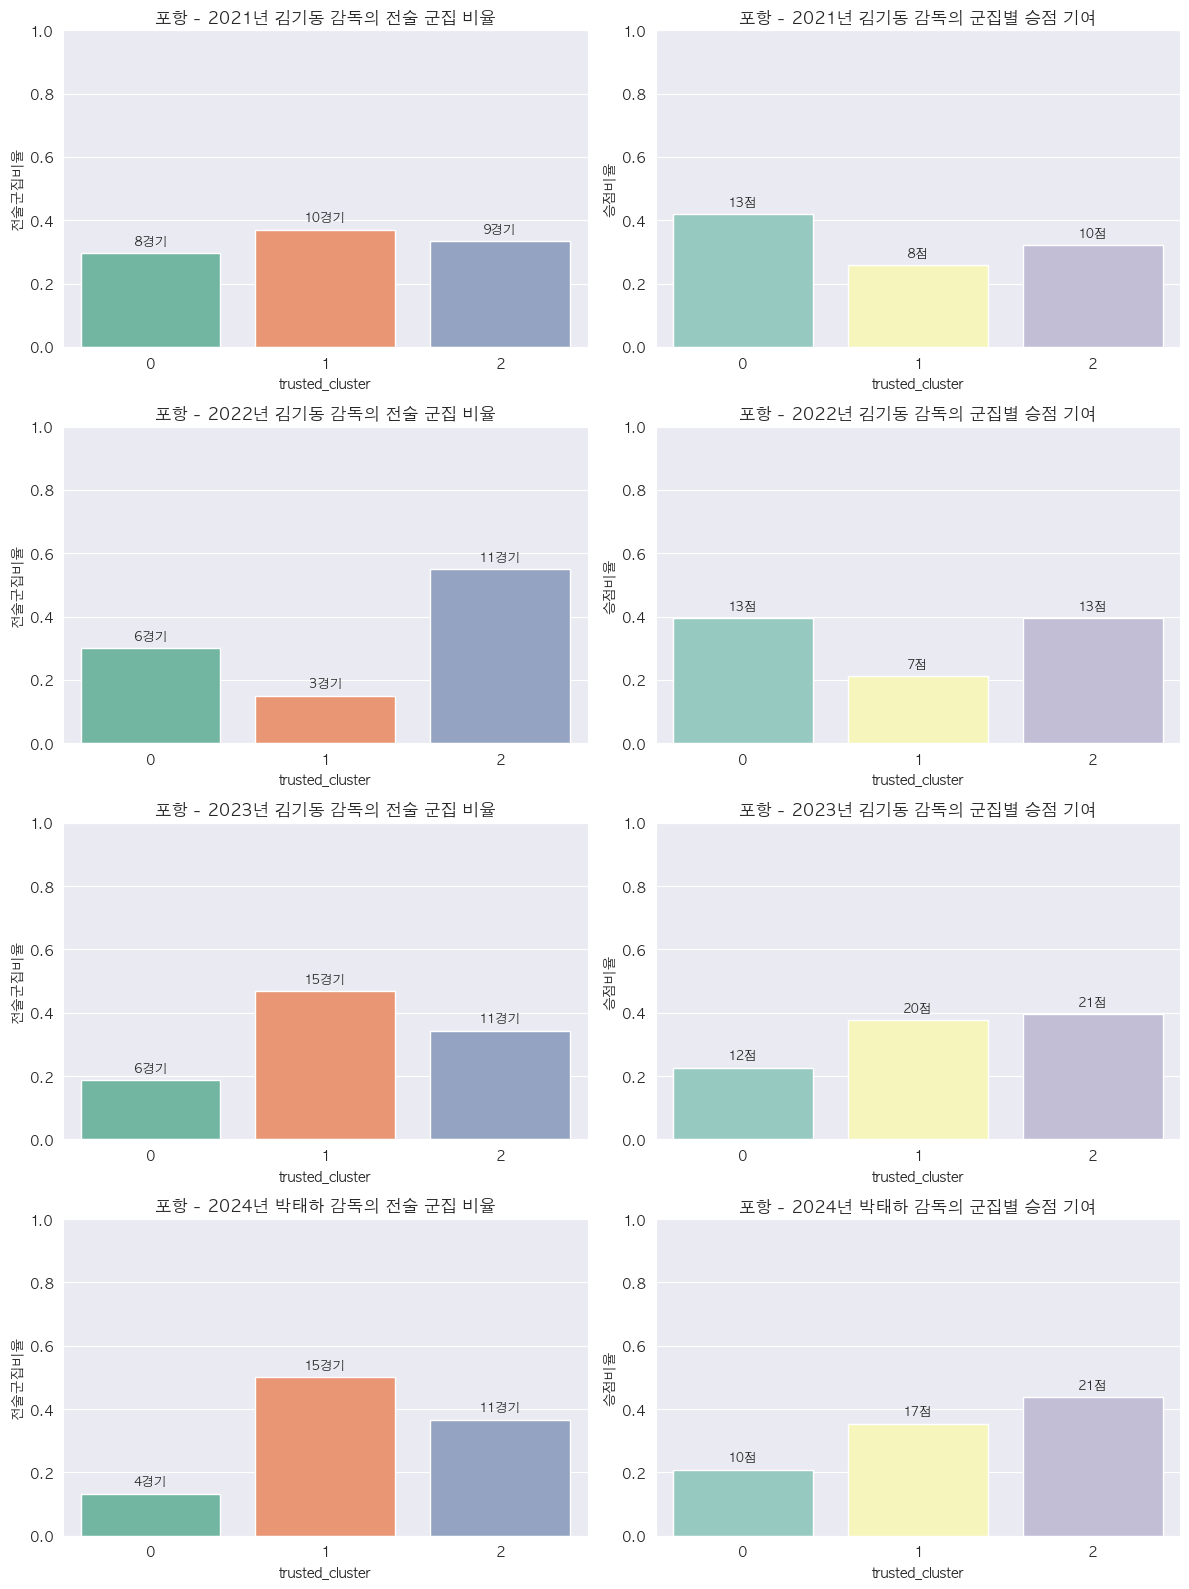

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

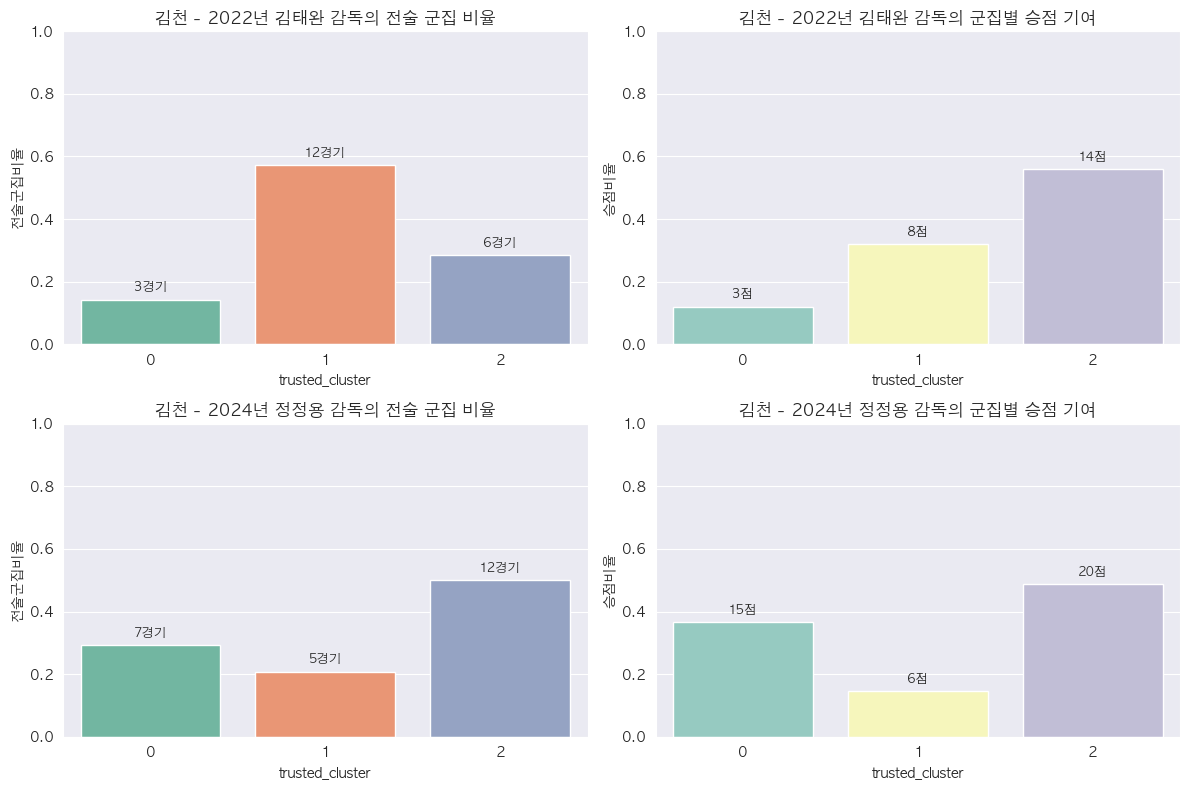

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_18878/1642205243.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

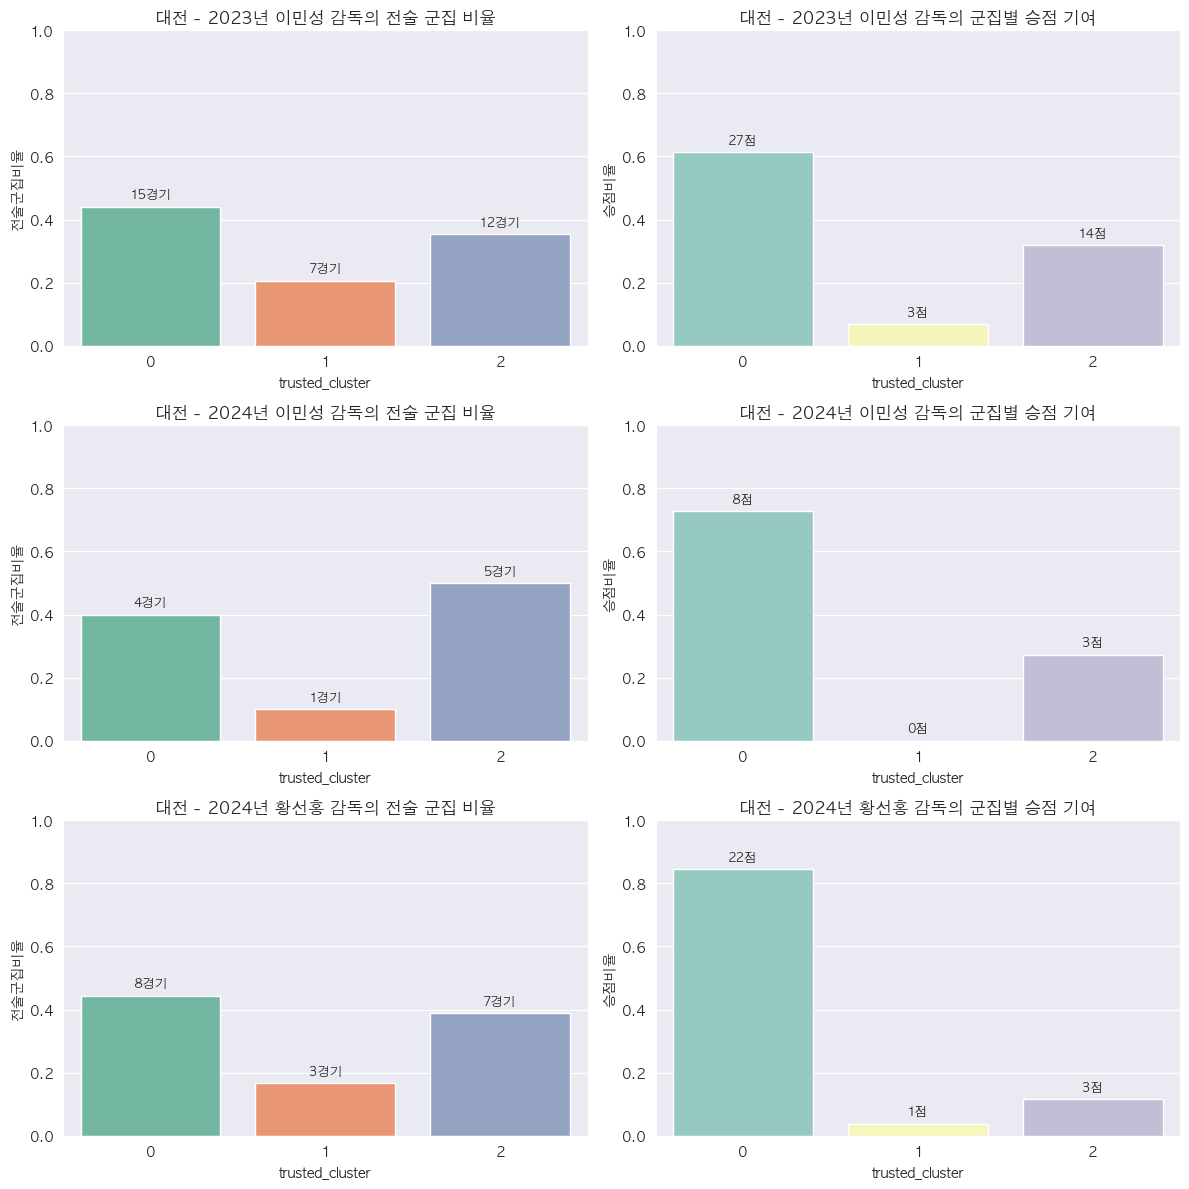

In [29]:
for team in filtered_df['구단'].unique():
    ratio_viz_by_manager(team)